<a href="https://colab.research.google.com/github/cheneeheng/Transformer-TF/blob/colab_dev/Cifar10_VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIFAR10 Classification**

Based on [CIFAR10_Keras_GPU.ipynb](https://github.com/katnoria/cifar10-native-vs-colab/blob/master/CIFAR10_Keras_GPU.ipynb) from [katnoria/cifar10-native-vs-colab](https://github.com/katnoria/cifar10-native-vs-colab) .

General info about the dataset:
- 50K Train, 10K Test
- 10 object classes


# Imports

In [14]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from time import time
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import tensorflow as tf
tf.__version__

'2.4.1'

# Data generator

In [15]:
from tensorflow.keras.datasets import cifar10

(x_trn_full, y_trn_full), (x_tst, y_tst) = cifar10.load_data()

# remove the last dimension
y_trn_full = y_trn_full.reshape(y_trn_full.shape[0],)
y_tst = y_tst.reshape(y_tst.shape[0],)

# perform in model.
# # normalize data to 0..1
# x_trn_full, x_tst = x_trn_full / 255.0, x_tst / 255.0

# create validation split
# split = 0.2
# x_trn, x_val, y_trn, y_val = train_test_split(
#     x_trn_full, y_trn_full, test_size=split, random_state=1969)
x_trn, x_val, y_trn, y_val = x_trn_full, x_tst, y_trn_full, y_tst

print(f'x_trn.shape: {x_trn.shape}')
print(f'y_trn.shape: {y_trn.shape}')
print(f'x_val.shape: {x_val.shape}')
print(f'y_val.shape: {y_val.shape}')
print(f'x_tst shape: {x_tst.shape}')
print(f'y_tst.shape: {y_tst.shape}')

x_trn.shape: (50000, 32, 32, 3)
y_trn.shape: (50000,)
x_val.shape: (10000, 32, 32, 3)
y_val.shape: (10000,)
x_tst shape: (10000, 32, 32, 3)
y_tst.shape: (10000,)


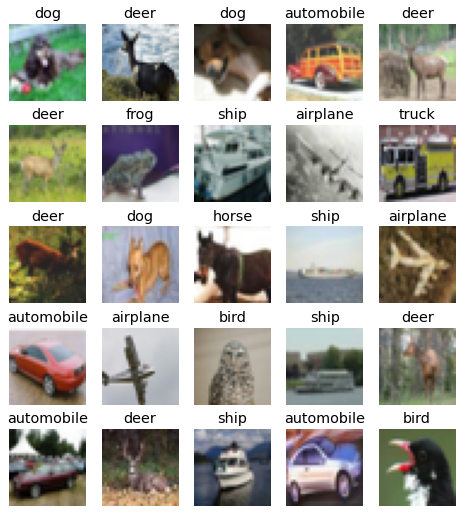

In [16]:
# pick 25 random images and plot
idxs = np.random.randint(x_trn.shape[0], size=25)
images = x_trn[idxs]
labels = y_trn[idxs]
classnames = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(5,5, figsize=(8,9))
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])
  ax.axis('off')
  idx = labels[i]
  ax.set_title(classnames[idx])
plt.show()

In [17]:
class Patches(tf.keras.layers.Layer):
  """Creates patches from an image. Implemented as a keras layer."""
  def __init__(self, patch_size: int):
    super().__init__()
    self.patch_size = patch_size

  def call(self, x):
    batch_size = tf.shape(x)[0]
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

  def get_config(self):
    return {"patch_size": self.patch_size}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


Image size: 32 X 32
Patch size: 4 X 4
Patches per image: 64
Elements per patch: 48


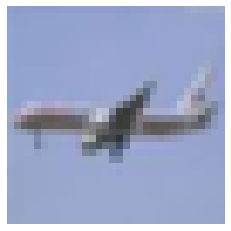

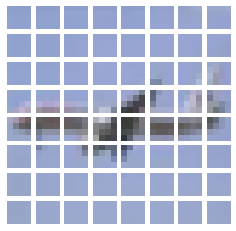

In [18]:
plt.figure(figsize=(4, 4))
image = x_trn[np.random.choice(range(x_trn.shape[0]))]
plt.imshow(image)
plt.axis("off")

image_size = 32
patch_size = 4

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [19]:
def data_generator(split: str, batch_size: int, shuffle_buffer: int = 10000):
  """Creates a tf.data.Dataset instance.

  Args:
      split: The type of data to generate, ['train', 'val', 'test'].
      batch_size: Batch size.
      shuffle_buffer: Number of elements used for shuffling.

  Returns:
      A tf.data.Dataset instance.

  Raises:
      ValueError: If `split` is not ['train', 'val', 'test'].

  """
  if split == 'train':
    ds = tf.data.Dataset.from_tensor_slices((x_trn, y_trn))
    ds = ds.shuffle(shuffle_buffer)
  elif split == 'val':
    ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  elif split == 'test':
    ds = tf.data.Dataset.from_tensor_slices((x_tst, y_tst))
  else:
    raise ValueError(f"Unknown data split : {split}")
  return ds.batch(batch_size)

# Model

A simple CNN example from the keras [CNN benchmark](https://github.com/keras-team/keras/blob/master/keras/benchmarks/keras_examples_benchmarks/cifar10_cnn_benchmark_test.py) .  
It is based on this [CNN example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) but the example is no longer available.


In [20]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Conv2D, 
  BatchNormalization, 
  MaxPool2D,
  Dropout,
  Flatten,
  Dense
)
from tensorflow.keras.initializers import TruncatedNormal, Constant, Zeros
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu
from tensorflow.keras.layers.experimental.preprocessing import (
  RandomFlip,
  RandomTranslation,
  RandomRotation,
  RandomZoom,
  Normalization,
  Rescaling,
  Resizing
)

def conv2d(filters, kernel_size, strides=(1, 1), padding='valid', **kwargs):
  return Conv2D(filters, 
                kernel_size, 
                strides, 
                padding=padding, 
                activation=relu,
                **kwargs)
  
def maxpool2d(**kwargs):
  return MaxPool2D([3, 3], 2, padding='valid', **kwargs)

class SmallCNN(Model):
  """SmallCNN implementation.
  
  Changes compared to the original model:
  - maxpool2d uses a kernel_size=3, stride=2.
  
  """

  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               preprocess: bool = False):
    super().__init__()

    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Model
    self.conv1 = conv2d(32, 3, name='conv1', padding='same')
    self.conv2 = conv2d(32, 3, name='conv2')
    self.pool2 = maxpool2d(name='pool1')
    self.drop2 = Dropout(0.5, name='drop2')
    self.conv3 = conv2d(64, 3, name='conv3', padding='same')
    self.conv4 = conv2d(64, 3, name='conv4')
    self.pool4 = maxpool2d(name='pool4')
    self.drop4 = Dropout(0.25, name='drop4')
    self.flat5 = Flatten(name='flat5')
    self.dens5 = Dense(512, activation=relu, name='dens5')
    self.drop5 = Dropout(0.5, name='drop5')
    self.dens6 = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)
    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)
    x = self.pool2(self.conv2(self.conv1(x)))
    x = self.drop2(x, training=training)
    x = self.pool4(self.conv4(self.conv3(x)))
    x = self.drop4(x, training=training)
    x = self.dens5(self.flat5(x))
    x = self.drop5(x, training=training)
    x = self.dens6(x)
    return x
  
  # https://stackoverflow.com/questions/55235212
  def model(self):
    x = Input(shape=(32, 32, 3))
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
    return {"num_classes": self.num_classes,
            "image_height": self.image_height,
            "image_width": self.image_width,
            "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
    return cls(**config)

[Vision Transformer](https://arxiv.org/abs/2010.11929) by Alexey Dosovitskiy et al.  
Code taken from this [example](https://keras.io/examples/vision/image_classification_with_vision_transformer/) .

In [28]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Layer,
  Add,
  BatchNormalization, 
  Conv2D, 
  Dense,
  Dropout,
  Embedding,
  Flatten,
  LayerNormalization,
  MaxPool2D,
  MultiHeadAttention
)
from tensorflow.keras.initializers import TruncatedNormal, Constant, Zeros
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu, gelu
from tensorflow.keras.layers.experimental.preprocessing import (
  Normalization,
  RandomFlip,
  RandomRotation,
  RandomZoom,
  Rescaling,
  Resizing,
)

def mlp(hidden_units: list, dropout_rate: float, name: str = ''):
  """Multilayer perceptron."""
  layers = []
  for idx, units in enumerate(hidden_units):
    layers.append(Dense(units, activation=gelu, name=f'{name}/dens{idx}'))
    layers.append(Dropout(dropout_rate, name=f'{name}/drop{idx}'))
  return layers

class MLP(Layer):
  """Multilayer perceptron."""
  def __init__(self, hidden_units: list, dropout_rate: float):
    super().__init__()
    self.hidden_units = hidden_units
    self.dropout_rate = dropout_rate
    
    self.layers = []
    self.dropouts = []
    for idx, units in enumerate(self.hidden_units):
      self.layers.append(Dense(units, activation=gelu, name=f'dens{idx}'))
      self.dropouts.append(Dropout(dropout_rate))

  def call(self, x, training: bool = None):
    for layer_i, dropout_i in zip(self.layers, self.dropouts):
        x = layer_i(x)
        x = dropout_i(x, training=training)
    return x
  
  def get_config(self):
    return {"hidden_units": self.hidden_units,
            "dropout_rate": self.dropout_rate}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class PatchEncoder(Layer):
  """Encoder for the image patches."""
  def __init__(self, num_patches: int, projection_dim: int):
    super().__init__()
    self.num_patches = num_patches
    self.projection_dim = projection_dim
    self.projection = Dense(units=self.projection_dim)
    self.position_embedding = Embedding(input_dim=num_patches,
                                        output_dim=self.projection_dim)

  def call(self, x):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(x) + self.position_embedding(positions)
    return encoded
  
  def get_config(self):
    return {"num_patches": self.num_patches,
            "projection_dim": self.projection_dim}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class VIT(Model):
  """Vision Transformer implementation.
  
  Changes compared to the original model:
  - maxpool2d uses a kernel_size=3, stride=2.
  
  """
  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               patch_size: int, 
               projection_dim: int,
               num_layers: int,
               num_heads: int,
               mlp_dims: list,
               classifier_mlp_dims: list,
               preprocess: bool = False):
    super().__init__()
    
    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.patch_size = patch_size
    self.projection_dim = projection_dim
    self.num_layers = num_layers
    self.num_heads = num_heads
    self.mlp_dims = mlp_dims
    self.classifier_mlp_dims = classifier_mlp_dims
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Patches
    self.patch = Patches(self.patch_size)
    num_patches = (self.image_height // self.patch_size) * \
                  (self.image_width // self.patch_size)
    self.patch_enc = PatchEncoder(num_patches, self.projection_dim)

    # Model
    self.transformer_blocks = []
    for idx in range(self.num_layers):
      block = []
      block += [LayerNormalization(epsilon=1e-6, name=f'ln{idx + 1}_1')]
      block += [MultiHeadAttention(self.num_heads, 
                                   self.projection_dim, 
                                   dropout=0.1, 
                                   name=f'mha{idx + 1}')]
      block += [Add(name=f'skip{idx + 1}_1')]
      block += [LayerNormalization(epsilon=1e-6, name=f'ln{idx + 1}_2')]
      block += [mlp(mlp_dims, dropout_rate=0.1, name=f'mlp{idx + 1}')]
      block += [Add(name=f'skip{idx + 1}_2')]
      self.transformer_blocks.append(block)

    self.lnorm = LayerNormalization(epsilon=1e-6, name='classifier_ln')
    self.flat = Flatten(name='classifier_flat')
    self.drop = Dropout(0.5, name='classifier_drop')
    self.mlp = mlp(self.classifier_mlp_dims, dropout_rate=0.5, 
                   name='classifier_mlp')
    self.logits = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)

    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)

    x = self.patch(x)
    x = self.patch_enc(x)
    
    for block in self.transformer_blocks:
      x_layer_norm_1 = block[0](x)
      x_attention    = block[1](x_layer_norm_1, x_layer_norm_1)
      x_skip         = block[2]([x_attention, x])
      x_layer_norm_2 = block[3](x_skip)
      x_mlp          = self._iterate_mlp(block[4], x_layer_norm_2)
      x              = block[5]([x_mlp, x_skip])
    
    x = self.lnorm(x)
    x = self.flat(x)
    x = self.drop(x, training=training)
    x = self._iterate_mlp(self.mlp, x)
    x = self.logits(x)
    return x
  
  @staticmethod
  def _iterate_mlp(mlp_layers: list, x: tf.Tensor):
    _x = x
    for mlp_i in mlp_layers:
      _x = mlp_i(_x)
    return _x

  # https://stackoverflow.com/questions/55235212
  def model(self):
    x = Input(shape=(32, 32, 3))
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
      return {"num_classes": self.num_classes,
              "image_height": self.image_height,
              "image_width": self.image_width,
              "patch_size": self.patch_size,
              "projection_dim": self.projection_dim,
              "num_layers": self.num_layers,
              "num_heads": self.num_heads,
              "mlp_dims": self.mlp_dims,
              "classifier_mlp_dims": self.classifier_mlp_dims,
              "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
      return cls(**config)

Save an initial copy of the weights.  
The weights will be used to initialize all the experiments, allowing for fair comparison.


In [22]:
%%script false 
# Kept as reference.

# # Saves a full copy of the model.
# model_SmallCNN = SmallCNN(num_classes=10, 
#                           image_height=32, 
#                           image_width=32,
#                           preprocess=False).model()
# model_SmallCNN.save('model_SmallCNN')

# # Loads model
# model_SmallCNN = tf.keras.models.load_model('model_SmallCNN')
# model_SmallCNN.summary()

# # Saves a full copy of the model.
# model_VIT = VIT(num_classes=10, 
#                 image_height=32, 
#                 image_width=32,
#                 patch_size=4, 
#                 projection_dim=32,
#                 num_layers=4,
#                 num_heads=4,
#                 mlp_dims=[64, 32],
#                 classifier_mlp_dims=[512],
#                 preprocess=False).model()
# model_VIT.save('model_VIT')

# # Loads model
# model_VIT = tf.keras.models.load_model('model_VIT')
# model_VIT.summary()

# # Saves only the weights of the model.
# model = SmallCNN(num_classes=10)
# model(tf.zeros([1,32,32,3]))
# model.save_weights('model.h5')

# # Loads weights
# model.load_weights('model.h5')
# model.preprocess = True
# for layer in model.model().layers:
#   print(layer.output)
# model.model().summary()

# Train

Training configs.

In [23]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc_metric_fn = tf.keras.metrics.SparseCategoricalAccuracy
batch_size = 256
shuffle_buffer = 50000
epochs = 50
learning_rate = 1e-3
num_classes = 10 
image_height = 32
image_width = 32

Keras model.compile(...) and model.fit(...) .


In [24]:
def train_and_eval(_model, _checkpoint_filepath):
  """Wrapper code for training and evaluating.

  Args:
      _model: A keras Model.
      _checkpoint_filepath: Path to save a checkpoint.

  Returns:
      A history instance that contains logged values per epoch.

  """
  _model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=loss_fn,
      metrics=[acc_metric_fn(name='sparse_categorical_accuracy')]
  )
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      _checkpoint_filepath,
      monitor="val_sparse_categorical_accuracy",
      save_best_only=True,
  )
  start = time()
  history = _model.fit(
      data_generator('train', batch_size, shuffle_buffer), 
      epochs=epochs, 
      steps_per_epoch=len(data_generator('train', batch_size, shuffle_buffer)),
      validation_data=data_generator('val', batch_size),
      callbacks=[checkpoint_callback],
  )
  end = time()
  print(f'Total training time {end - start} seconds')
  return history

Native TF with GradientTape.  
This is exactly the same as using compite(...) and fit(...) in keras.  
However, this exposes the gradient and the train loop, allowing for more flexibility.

In [25]:
%%script false
# This is just for reference.

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = acc_metric_fn(name='sparse_categorical_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = acc_metric_fn(name='val_sparse_categorical_accuracy')

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_fn(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  # Container to keep the results.
  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def val_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  v_loss = loss_fn(labels, predictions)
  # Container to keep the results.
  val_loss(v_loss)
  val_accuracy(labels, predictions)

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
progbar = tf.keras.utils.Progbar
trn_ds = data_generator('train', batch_size, shuffle_buffer)
val_ds = data_generator('val', batch_size)

start = time()
for epoch in range(epochs):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  print(f"Epoch {epoch+1}/{epochs}")
  pb_i = progbar(steps_per_epoch=len(trn_ds), 
                 stateful_metrics=['Loss', 'Accuracy',
                                   'Val Loss', 'Val Accuracy'])
  
  for idx, (images, labels) in enumerate(trn_ds):
    train_step(images, labels)
    if idx + 1 < mini_batches:
      pb_i.add(1, values=[('Loss', train_loss.result()), 
                          ('Accuracy', train_accuracy.result())])

  for val_images, val_labels in val_ds:
    val_step(val_images, val_labels)
  pb_i.add(1, values=[('Loss', train_loss.result()), 
                      ('Accuracy', train_accuracy.result()),
                      ('Val Loss', val_loss.result()), 
                      ('Val Accuracy', val_accuracy.result())])

  train_losses.append(train_loss.result())
  train_accuracies.append(train_accuracy.result())
  val_losses.append(val_loss.result())
  val_accuracies.append(val_accuracy.result())

end = time()

print(f'Total training time {end - start} seconds')

**Experiment 1**  
Model : CNN  
Preprocessing : False  
Batch size : 256

In [26]:
model = SmallCNN(num_classes=num_classes, 
                 image_height=image_height, 
                 image_width=image_width,
                 preprocess=False).model()
model.summary()
history_cnn = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropout)              (None, 14, 14, 32)        0   

**Experiment 2**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 4x4

In [29]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=4, 
            projection_dim=32,
            num_layers=4,
            num_heads=4,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_4x4 = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_3 (Patches)             (None, None, 48)     0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 2/50
196/196 [==============================] - 9s 44ms/step - loss: 1.7941 - sparse_categorical_accuracy: 0.3380 - val_loss: 1.5925 - val_sparse_categorical_accuracy: 0.4322


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 3/50
196/196 [==============================] - 9s 44ms/step - loss: 1.6187 - sparse_categorical_accuracy: 0.4067 - val_loss: 1.4148 - val_sparse_categorical_accuracy: 0.4808


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 4/50
196/196 [==============================] - 9s 44ms/step - loss: 1.5301 - sparse_categorical_accuracy: 0.4468 - val_loss: 1.3545 - val_sparse_categorical_accuracy: 0.5083


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 5/50
196/196 [==============================] - 9s 44ms/step - loss: 1.4374 - sparse_categorical_accuracy: 0.4744 - val_loss: 1.2484 - val_sparse_categorical_accuracy: 0.5444


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 6/50
196/196 [==============================] - 9s 44ms/step - loss: 1.3759 - sparse_categorical_accuracy: 0.5030 - val_loss: 1.2294 - val_sparse_categorical_accuracy: 0.5523


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 7/50
196/196 [==============================] - 9s 44ms/step - loss: 1.3287 - sparse_categorical_accuracy: 0.5178 - val_loss: 1.2116 - val_sparse_categorical_accuracy: 0.5529


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 8/50
196/196 [==============================] - 9s 44ms/step - loss: 1.2962 - sparse_categorical_accuracy: 0.5317 - val_loss: 1.1508 - val_sparse_categorical_accuracy: 0.5832


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 9/50
196/196 [==============================] - 9s 44ms/step - loss: 1.2593 - sparse_categorical_accuracy: 0.5428 - val_loss: 1.1313 - val_sparse_categorical_accuracy: 0.5981


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 10/50
196/196 [==============================] - 9s 44ms/step - loss: 1.2194 - sparse_categorical_accuracy: 0.5634 - val_loss: 1.1245 - val_sparse_categorical_accuracy: 0.5917
Epoch 11/50
196/196 [==============================] - 9s 44ms/step - loss: 1.1865 - sparse_categorical_accuracy: 0.5753 - val_loss: 1.0859 - val_sparse_categorical_accuracy: 0.6083


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 12/50
196/196 [==============================] - 9s 44ms/step - loss: 1.1530 - sparse_categorical_accuracy: 0.5902 - val_loss: 1.0508 - val_sparse_categorical_accuracy: 0.6244


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 13/50
196/196 [==============================] - 9s 44ms/step - loss: 1.1212 - sparse_categorical_accuracy: 0.5953 - val_loss: 1.0475 - val_sparse_categorical_accuracy: 0.6235
Epoch 14/50
196/196 [==============================] - 9s 44ms/step - loss: 1.0914 - sparse_categorical_accuracy: 0.6106 - val_loss: 1.0772 - val_sparse_categorical_accuracy: 0.6185
Epoch 15/50
196/196 [==============================] - 9s 44ms/step - loss: 1.0856 - sparse_categorical_accuracy: 0.6122 - val_loss: 1.0322 - val_sparse_categorical_accuracy: 0.6273


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 16/50
196/196 [==============================] - 9s 44ms/step - loss: 1.0483 - sparse_categorical_accuracy: 0.6240 - val_loss: 1.0098 - val_sparse_categorical_accuracy: 0.6401


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 17/50
196/196 [==============================] - 9s 44ms/step - loss: 1.0189 - sparse_categorical_accuracy: 0.6380 - val_loss: 0.9962 - val_sparse_categorical_accuracy: 0.6435


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 18/50
196/196 [==============================] - 9s 45ms/step - loss: 1.0079 - sparse_categorical_accuracy: 0.6415 - val_loss: 0.9700 - val_sparse_categorical_accuracy: 0.6556


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 19/50
196/196 [==============================] - 9s 45ms/step - loss: 0.9835 - sparse_categorical_accuracy: 0.6488 - val_loss: 0.9696 - val_sparse_categorical_accuracy: 0.6602


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 20/50
196/196 [==============================] - 9s 45ms/step - loss: 0.9680 - sparse_categorical_accuracy: 0.6548 - val_loss: 0.9372 - val_sparse_categorical_accuracy: 0.6701


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 21/50
196/196 [==============================] - 9s 45ms/step - loss: 0.9387 - sparse_categorical_accuracy: 0.6664 - val_loss: 0.9341 - val_sparse_categorical_accuracy: 0.6652
Epoch 22/50
196/196 [==============================] - 9s 45ms/step - loss: 0.9355 - sparse_categorical_accuracy: 0.6692 - val_loss: 0.9184 - val_sparse_categorical_accuracy: 0.6787


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 23/50
196/196 [==============================] - 9s 45ms/step - loss: 0.9148 - sparse_categorical_accuracy: 0.6742 - val_loss: 0.9161 - val_sparse_categorical_accuracy: 0.6744
Epoch 24/50
196/196 [==============================] - 9s 44ms/step - loss: 0.8919 - sparse_categorical_accuracy: 0.6787 - val_loss: 0.9058 - val_sparse_categorical_accuracy: 0.6788


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 25/50
196/196 [==============================] - 9s 45ms/step - loss: 0.8796 - sparse_categorical_accuracy: 0.6896 - val_loss: 0.9124 - val_sparse_categorical_accuracy: 0.6782
Epoch 26/50
196/196 [==============================] - 9s 45ms/step - loss: 0.8640 - sparse_categorical_accuracy: 0.6925 - val_loss: 0.8968 - val_sparse_categorical_accuracy: 0.6850


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 27/50
196/196 [==============================] - 9s 44ms/step - loss: 0.8431 - sparse_categorical_accuracy: 0.6976 - val_loss: 0.8587 - val_sparse_categorical_accuracy: 0.6950


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 28/50
196/196 [==============================] - 9s 44ms/step - loss: 0.8269 - sparse_categorical_accuracy: 0.7057 - val_loss: 0.8906 - val_sparse_categorical_accuracy: 0.6871
Epoch 29/50
196/196 [==============================] - 9s 44ms/step - loss: 0.8175 - sparse_categorical_accuracy: 0.7075 - val_loss: 0.8654 - val_sparse_categorical_accuracy: 0.6975


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 30/50
196/196 [==============================] - 9s 45ms/step - loss: 0.7895 - sparse_categorical_accuracy: 0.7189 - val_loss: 0.8593 - val_sparse_categorical_accuracy: 0.6957
Epoch 31/50
196/196 [==============================] - 9s 45ms/step - loss: 0.7838 - sparse_categorical_accuracy: 0.7239 - val_loss: 0.8510 - val_sparse_categorical_accuracy: 0.7041


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 32/50
196/196 [==============================] - 9s 44ms/step - loss: 0.7851 - sparse_categorical_accuracy: 0.7206 - val_loss: 0.8478 - val_sparse_categorical_accuracy: 0.6989
Epoch 33/50
196/196 [==============================] - 9s 44ms/step - loss: 0.7542 - sparse_categorical_accuracy: 0.7307 - val_loss: 0.8289 - val_sparse_categorical_accuracy: 0.7086


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 34/50
196/196 [==============================] - 9s 44ms/step - loss: 0.7478 - sparse_categorical_accuracy: 0.7347 - val_loss: 0.8256 - val_sparse_categorical_accuracy: 0.7070
Epoch 35/50
196/196 [==============================] - 9s 44ms/step - loss: 0.7270 - sparse_categorical_accuracy: 0.7421 - val_loss: 0.8364 - val_sparse_categorical_accuracy: 0.7077
Epoch 36/50
196/196 [==============================] - 9s 44ms/step - loss: 0.7230 - sparse_categorical_accuracy: 0.7435 - val_loss: 0.8278 - val_sparse_categorical_accuracy: 0.7117


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 37/50
196/196 [==============================] - 9s 44ms/step - loss: 0.7199 - sparse_categorical_accuracy: 0.7415 - val_loss: 0.8370 - val_sparse_categorical_accuracy: 0.7107
Epoch 38/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6966 - sparse_categorical_accuracy: 0.7503 - val_loss: 0.8128 - val_sparse_categorical_accuracy: 0.7164


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 39/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6885 - sparse_categorical_accuracy: 0.7538 - val_loss: 0.8165 - val_sparse_categorical_accuracy: 0.7121
Epoch 40/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6962 - sparse_categorical_accuracy: 0.7539 - val_loss: 0.8032 - val_sparse_categorical_accuracy: 0.7175


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 41/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6720 - sparse_categorical_accuracy: 0.7603 - val_loss: 0.8048 - val_sparse_categorical_accuracy: 0.7206


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 42/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6625 - sparse_categorical_accuracy: 0.7637 - val_loss: 0.8258 - val_sparse_categorical_accuracy: 0.7088
Epoch 43/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6692 - sparse_categorical_accuracy: 0.7649 - val_loss: 0.8095 - val_sparse_categorical_accuracy: 0.7230


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 44/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6430 - sparse_categorical_accuracy: 0.7717 - val_loss: 0.7892 - val_sparse_categorical_accuracy: 0.7258


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 45/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6368 - sparse_categorical_accuracy: 0.7742 - val_loss: 0.7974 - val_sparse_categorical_accuracy: 0.7247
Epoch 46/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6353 - sparse_categorical_accuracy: 0.7736 - val_loss: 0.7949 - val_sparse_categorical_accuracy: 0.7236
Epoch 47/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6217 - sparse_categorical_accuracy: 0.7770 - val_loss: 0.7836 - val_sparse_categorical_accuracy: 0.7325


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 48/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6079 - sparse_categorical_accuracy: 0.7820 - val_loss: 0.7832 - val_sparse_categorical_accuracy: 0.7294
Epoch 49/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6019 - sparse_categorical_accuracy: 0.7884 - val_loss: 0.7805 - val_sparse_categorical_accuracy: 0.7311
Epoch 50/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6016 - sparse_categorical_accuracy: 0.7852 - val_loss: 0.7957 - val_sparse_categorical_accuracy: 0.7311
Total training time 652.1844100952148 seconds


**Experiment 3**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 16x16

In [30]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=16, 
            projection_dim=32,
            num_layers=4,
            num_heads=4,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_16x16 = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16')

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_4 (Patches)             (None, None, 768)    0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 2/50
196/196 [==============================] - 3s 16ms/step - loss: 1.8711 - sparse_categorical_accuracy: 0.3127 - val_loss: 1.7194 - val_sparse_categorical_accuracy: 0.3768


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 3/50
196/196 [==============================] - 3s 16ms/step - loss: 1.7616 - sparse_categorical_accuracy: 0.3601 - val_loss: 1.5871 - val_sparse_categorical_accuracy: 0.4281


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 4/50
196/196 [==============================] - 3s 16ms/step - loss: 1.6888 - sparse_categorical_accuracy: 0.3867 - val_loss: 1.5386 - val_sparse_categorical_accuracy: 0.4463


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 5/50
196/196 [==============================] - 3s 16ms/step - loss: 1.6386 - sparse_categorical_accuracy: 0.4061 - val_loss: 1.5057 - val_sparse_categorical_accuracy: 0.4506


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 6/50
196/196 [==============================] - 3s 16ms/step - loss: 1.5986 - sparse_categorical_accuracy: 0.4252 - val_loss: 1.4953 - val_sparse_categorical_accuracy: 0.4662


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 7/50
196/196 [==============================] - 3s 16ms/step - loss: 1.5844 - sparse_categorical_accuracy: 0.4315 - val_loss: 1.4550 - val_sparse_categorical_accuracy: 0.4758


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 8/50
196/196 [==============================] - 3s 16ms/step - loss: 1.5354 - sparse_categorical_accuracy: 0.4485 - val_loss: 1.4432 - val_sparse_categorical_accuracy: 0.4766


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 9/50
196/196 [==============================] - 3s 16ms/step - loss: 1.5249 - sparse_categorical_accuracy: 0.4489 - val_loss: 1.4144 - val_sparse_categorical_accuracy: 0.4887


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 10/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4949 - sparse_categorical_accuracy: 0.4575 - val_loss: 1.4069 - val_sparse_categorical_accuracy: 0.4949


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 11/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4755 - sparse_categorical_accuracy: 0.4680 - val_loss: 1.3786 - val_sparse_categorical_accuracy: 0.5062


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 12/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4508 - sparse_categorical_accuracy: 0.4754 - val_loss: 1.3739 - val_sparse_categorical_accuracy: 0.5059
Epoch 13/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4393 - sparse_categorical_accuracy: 0.4830 - val_loss: 1.3619 - val_sparse_categorical_accuracy: 0.5076


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 14/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4255 - sparse_categorical_accuracy: 0.4869 - val_loss: 1.3486 - val_sparse_categorical_accuracy: 0.5153


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 15/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4099 - sparse_categorical_accuracy: 0.4957 - val_loss: 1.3579 - val_sparse_categorical_accuracy: 0.5098
Epoch 16/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4036 - sparse_categorical_accuracy: 0.4955 - val_loss: 1.3354 - val_sparse_categorical_accuracy: 0.5143
Epoch 17/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3810 - sparse_categorical_accuracy: 0.5041 - val_loss: 1.3396 - val_sparse_categorical_accuracy: 0.5252


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 18/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3678 - sparse_categorical_accuracy: 0.5051 - val_loss: 1.3441 - val_sparse_categorical_accuracy: 0.5141
Epoch 19/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3614 - sparse_categorical_accuracy: 0.5116 - val_loss: 1.3333 - val_sparse_categorical_accuracy: 0.5209
Epoch 20/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3555 - sparse_categorical_accuracy: 0.5129 - val_loss: 1.3254 - val_sparse_categorical_accuracy: 0.5269


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 21/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3438 - sparse_categorical_accuracy: 0.5174 - val_loss: 1.3176 - val_sparse_categorical_accuracy: 0.5280


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 22/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3328 - sparse_categorical_accuracy: 0.5232 - val_loss: 1.3231 - val_sparse_categorical_accuracy: 0.5252
Epoch 23/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3273 - sparse_categorical_accuracy: 0.5262 - val_loss: 1.3151 - val_sparse_categorical_accuracy: 0.5255
Epoch 24/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3114 - sparse_categorical_accuracy: 0.5297 - val_loss: 1.3096 - val_sparse_categorical_accuracy: 0.5280
Epoch 25/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3078 - sparse_categorical_accuracy: 0.5272 - val_loss: 1.2976 - val_sparse_categorical_accuracy: 0.5352


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 26/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2943 - sparse_categorical_accuracy: 0.5349 - val_loss: 1.3056 - val_sparse_categorical_accuracy: 0.5327
Epoch 27/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2813 - sparse_categorical_accuracy: 0.5445 - val_loss: 1.3051 - val_sparse_categorical_accuracy: 0.5326
Epoch 28/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2839 - sparse_categorical_accuracy: 0.5411 - val_loss: 1.2981 - val_sparse_categorical_accuracy: 0.5345
Epoch 29/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2774 - sparse_categorical_accuracy: 0.5402 - val_loss: 1.3135 - val_sparse_categorical_accuracy: 0.5334
Epoch 30/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2655 - sparse_categorical_accuracy: 0.5472 - val_loss: 1.2922 - val_sparse_categorical_accuracy: 0.5386


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 31/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2552 - sparse_categorical_accuracy: 0.5502 - val_loss: 1.2895 - val_sparse_categorical_accuracy: 0.5423


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 32/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2541 - sparse_categorical_accuracy: 0.5483 - val_loss: 1.2966 - val_sparse_categorical_accuracy: 0.5367
Epoch 33/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2417 - sparse_categorical_accuracy: 0.5528 - val_loss: 1.2831 - val_sparse_categorical_accuracy: 0.5363
Epoch 34/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2410 - sparse_categorical_accuracy: 0.5544 - val_loss: 1.2976 - val_sparse_categorical_accuracy: 0.5416
Epoch 35/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2298 - sparse_categorical_accuracy: 0.5567 - val_loss: 1.2972 - val_sparse_categorical_accuracy: 0.5425


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 36/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2282 - sparse_categorical_accuracy: 0.5599 - val_loss: 1.2873 - val_sparse_categorical_accuracy: 0.5359
Epoch 37/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2140 - sparse_categorical_accuracy: 0.5664 - val_loss: 1.2926 - val_sparse_categorical_accuracy: 0.5396
Epoch 38/50
196/196 [==============================] - 3s 15ms/step - loss: 1.2140 - sparse_categorical_accuracy: 0.5613 - val_loss: 1.2954 - val_sparse_categorical_accuracy: 0.5395
Epoch 39/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1992 - sparse_categorical_accuracy: 0.5692 - val_loss: 1.2757 - val_sparse_categorical_accuracy: 0.5430


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 40/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1982 - sparse_categorical_accuracy: 0.5672 - val_loss: 1.2896 - val_sparse_categorical_accuracy: 0.5433


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 41/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1884 - sparse_categorical_accuracy: 0.5723 - val_loss: 1.2881 - val_sparse_categorical_accuracy: 0.5395
Epoch 42/50
196/196 [==============================] - 3s 15ms/step - loss: 1.1896 - sparse_categorical_accuracy: 0.5735 - val_loss: 1.3037 - val_sparse_categorical_accuracy: 0.5345
Epoch 43/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1775 - sparse_categorical_accuracy: 0.5784 - val_loss: 1.2965 - val_sparse_categorical_accuracy: 0.5384
Epoch 44/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1739 - sparse_categorical_accuracy: 0.5781 - val_loss: 1.3090 - val_sparse_categorical_accuracy: 0.5356
Epoch 45/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1798 - sparse_categorical_accuracy: 0.5723 - val_loss: 1.2882 - val_sparse_categorical_accuracy: 0.5422
Epoch 46/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1589 - spars

**Experiment 4**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 8x8

In [31]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=8, 
            projection_dim=32,
            num_layers=4,
            num_heads=4,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_8x8 = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8')

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_5 (Patches)             (None, None, 192)    0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 2/50
196/196 [==============================] - 4s 18ms/step - loss: 1.8366 - sparse_categorical_accuracy: 0.3279 - val_loss: 1.5563 - val_sparse_categorical_accuracy: 0.4467


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 3/50
196/196 [==============================] - 4s 18ms/step - loss: 1.6665 - sparse_categorical_accuracy: 0.3983 - val_loss: 1.4747 - val_sparse_categorical_accuracy: 0.4712


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 4/50
196/196 [==============================] - 4s 18ms/step - loss: 1.5815 - sparse_categorical_accuracy: 0.4272 - val_loss: 1.4194 - val_sparse_categorical_accuracy: 0.4832


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 5/50
196/196 [==============================] - 4s 19ms/step - loss: 1.5182 - sparse_categorical_accuracy: 0.4505 - val_loss: 1.3554 - val_sparse_categorical_accuracy: 0.5118


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 6/50
196/196 [==============================] - 4s 18ms/step - loss: 1.4674 - sparse_categorical_accuracy: 0.4719 - val_loss: 1.3362 - val_sparse_categorical_accuracy: 0.5183


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 7/50
196/196 [==============================] - 4s 19ms/step - loss: 1.4373 - sparse_categorical_accuracy: 0.4808 - val_loss: 1.3100 - val_sparse_categorical_accuracy: 0.5287


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 8/50
196/196 [==============================] - 4s 19ms/step - loss: 1.3964 - sparse_categorical_accuracy: 0.4984 - val_loss: 1.2869 - val_sparse_categorical_accuracy: 0.5405


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 9/50
196/196 [==============================] - 4s 18ms/step - loss: 1.3538 - sparse_categorical_accuracy: 0.5101 - val_loss: 1.2349 - val_sparse_categorical_accuracy: 0.5580


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 10/50
196/196 [==============================] - 4s 18ms/step - loss: 1.3314 - sparse_categorical_accuracy: 0.5180 - val_loss: 1.2162 - val_sparse_categorical_accuracy: 0.5645


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 11/50
196/196 [==============================] - 4s 19ms/step - loss: 1.3000 - sparse_categorical_accuracy: 0.5317 - val_loss: 1.2229 - val_sparse_categorical_accuracy: 0.5663


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 12/50
196/196 [==============================] - 4s 18ms/step - loss: 1.2684 - sparse_categorical_accuracy: 0.5461 - val_loss: 1.1928 - val_sparse_categorical_accuracy: 0.5736


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 13/50
196/196 [==============================] - 4s 18ms/step - loss: 1.2568 - sparse_categorical_accuracy: 0.5471 - val_loss: 1.1681 - val_sparse_categorical_accuracy: 0.5799


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 14/50
196/196 [==============================] - 4s 18ms/step - loss: 1.2385 - sparse_categorical_accuracy: 0.5581 - val_loss: 1.1558 - val_sparse_categorical_accuracy: 0.5816


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 15/50
196/196 [==============================] - 4s 18ms/step - loss: 1.2068 - sparse_categorical_accuracy: 0.5704 - val_loss: 1.1581 - val_sparse_categorical_accuracy: 0.5931


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 16/50
196/196 [==============================] - 4s 18ms/step - loss: 1.1986 - sparse_categorical_accuracy: 0.5703 - val_loss: 1.1546 - val_sparse_categorical_accuracy: 0.5858
Epoch 17/50
196/196 [==============================] - 4s 18ms/step - loss: 1.1838 - sparse_categorical_accuracy: 0.5819 - val_loss: 1.1331 - val_sparse_categorical_accuracy: 0.5892
Epoch 18/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1658 - sparse_categorical_accuracy: 0.5806 - val_loss: 1.1381 - val_sparse_categorical_accuracy: 0.5939


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 19/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1572 - sparse_categorical_accuracy: 0.5876 - val_loss: 1.1116 - val_sparse_categorical_accuracy: 0.6006


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 20/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1314 - sparse_categorical_accuracy: 0.5958 - val_loss: 1.1020 - val_sparse_categorical_accuracy: 0.6037


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 21/50
196/196 [==============================] - 4s 18ms/step - loss: 1.1099 - sparse_categorical_accuracy: 0.6044 - val_loss: 1.0936 - val_sparse_categorical_accuracy: 0.6098


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 22/50
196/196 [==============================] - 4s 18ms/step - loss: 1.1095 - sparse_categorical_accuracy: 0.6051 - val_loss: 1.0861 - val_sparse_categorical_accuracy: 0.6119


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 23/50
196/196 [==============================] - 4s 18ms/step - loss: 1.0880 - sparse_categorical_accuracy: 0.6094 - val_loss: 1.0779 - val_sparse_categorical_accuracy: 0.6198


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 24/50
196/196 [==============================] - 4s 18ms/step - loss: 1.0872 - sparse_categorical_accuracy: 0.6127 - val_loss: 1.0841 - val_sparse_categorical_accuracy: 0.6136
Epoch 25/50
196/196 [==============================] - 4s 18ms/step - loss: 1.0694 - sparse_categorical_accuracy: 0.6202 - val_loss: 1.0704 - val_sparse_categorical_accuracy: 0.6177
Epoch 26/50
196/196 [==============================] - 4s 18ms/step - loss: 1.0643 - sparse_categorical_accuracy: 0.6225 - val_loss: 1.0501 - val_sparse_categorical_accuracy: 0.6233


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 27/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0620 - sparse_categorical_accuracy: 0.6213 - val_loss: 1.0647 - val_sparse_categorical_accuracy: 0.6194
Epoch 28/50
196/196 [==============================] - 4s 18ms/step - loss: 1.0531 - sparse_categorical_accuracy: 0.6254 - val_loss: 1.0485 - val_sparse_categorical_accuracy: 0.6265


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 29/50
196/196 [==============================] - 4s 18ms/step - loss: 1.0333 - sparse_categorical_accuracy: 0.6309 - val_loss: 1.0568 - val_sparse_categorical_accuracy: 0.6233
Epoch 30/50
196/196 [==============================] - 4s 18ms/step - loss: 1.0183 - sparse_categorical_accuracy: 0.6321 - val_loss: 1.0400 - val_sparse_categorical_accuracy: 0.6256
Epoch 31/50
196/196 [==============================] - 4s 18ms/step - loss: 1.0251 - sparse_categorical_accuracy: 0.6315 - val_loss: 1.0445 - val_sparse_categorical_accuracy: 0.6259
Epoch 32/50
196/196 [==============================] - 4s 18ms/step - loss: 1.0040 - sparse_categorical_accuracy: 0.6442 - val_loss: 1.0379 - val_sparse_categorical_accuracy: 0.6304


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 33/50
196/196 [==============================] - 4s 18ms/step - loss: 1.0022 - sparse_categorical_accuracy: 0.6438 - val_loss: 1.0231 - val_sparse_categorical_accuracy: 0.6358


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 34/50
196/196 [==============================] - 4s 19ms/step - loss: 0.9933 - sparse_categorical_accuracy: 0.6476 - val_loss: 1.0229 - val_sparse_categorical_accuracy: 0.6354
Epoch 35/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9906 - sparse_categorical_accuracy: 0.6441 - val_loss: 1.0285 - val_sparse_categorical_accuracy: 0.6340
Epoch 36/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9846 - sparse_categorical_accuracy: 0.6477 - val_loss: 1.0205 - val_sparse_categorical_accuracy: 0.6401


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 37/50
196/196 [==============================] - 4s 19ms/step - loss: 0.9781 - sparse_categorical_accuracy: 0.6498 - val_loss: 1.0203 - val_sparse_categorical_accuracy: 0.6366
Epoch 38/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9557 - sparse_categorical_accuracy: 0.6609 - val_loss: 1.0075 - val_sparse_categorical_accuracy: 0.6440


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 39/50
196/196 [==============================] - 4s 19ms/step - loss: 0.9569 - sparse_categorical_accuracy: 0.6577 - val_loss: 1.0218 - val_sparse_categorical_accuracy: 0.6386
Epoch 40/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9455 - sparse_categorical_accuracy: 0.6615 - val_loss: 1.0192 - val_sparse_categorical_accuracy: 0.6386
Epoch 41/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9587 - sparse_categorical_accuracy: 0.6564 - val_loss: 1.0221 - val_sparse_categorical_accuracy: 0.6415
Epoch 42/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9321 - sparse_categorical_accuracy: 0.6664 - val_loss: 0.9955 - val_sparse_categorical_accuracy: 0.6494


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 43/50
196/196 [==============================] - 4s 19ms/step - loss: 0.9250 - sparse_categorical_accuracy: 0.6690 - val_loss: 1.0231 - val_sparse_categorical_accuracy: 0.6418
Epoch 44/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9330 - sparse_categorical_accuracy: 0.6670 - val_loss: 1.0065 - val_sparse_categorical_accuracy: 0.6439
Epoch 45/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9147 - sparse_categorical_accuracy: 0.6740 - val_loss: 1.0110 - val_sparse_categorical_accuracy: 0.6505


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 46/50
196/196 [==============================] - 4s 19ms/step - loss: 0.9197 - sparse_categorical_accuracy: 0.6721 - val_loss: 0.9973 - val_sparse_categorical_accuracy: 0.6528


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 47/50
196/196 [==============================] - 4s 19ms/step - loss: 0.9054 - sparse_categorical_accuracy: 0.6723 - val_loss: 1.0082 - val_sparse_categorical_accuracy: 0.6432
Epoch 48/50
196/196 [==============================] - 4s 19ms/step - loss: 0.9016 - sparse_categorical_accuracy: 0.6762 - val_loss: 1.0051 - val_sparse_categorical_accuracy: 0.6463
Epoch 49/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9003 - sparse_categorical_accuracy: 0.6757 - val_loss: 0.9868 - val_sparse_categorical_accuracy: 0.6533


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 50/50
196/196 [==============================] - 4s 18ms/step - loss: 0.8885 - sparse_categorical_accuracy: 0.6776 - val_loss: 0.9905 - val_sparse_categorical_accuracy: 0.6495
Total training time 398.0211012363434 seconds


**Experiment 5**  
Model : VIT  
Preprocessing : True  
Batch size : 256  
Patch : 8x8

In [32]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=8, 
            projection_dim=32,
            num_layers=4,
            num_heads=4,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=True).model()
model.summary()
history_vit_8x8_pre = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess')

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
data_aug_flip (RandomFlip)      (None, 32, 32, 3)    0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 2/50
196/196 [==============================] - 4s 19ms/step - loss: 1.8533 - sparse_categorical_accuracy: 0.3207 - val_loss: 1.5616 - val_sparse_categorical_accuracy: 0.4412


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 3/50
196/196 [==============================] - 4s 19ms/step - loss: 1.6694 - sparse_categorical_accuracy: 0.3938 - val_loss: 1.4623 - val_sparse_categorical_accuracy: 0.4750


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 4/50
196/196 [==============================] - 4s 20ms/step - loss: 1.6001 - sparse_categorical_accuracy: 0.4197 - val_loss: 1.4157 - val_sparse_categorical_accuracy: 0.4887


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 5/50
196/196 [==============================] - 4s 20ms/step - loss: 1.5565 - sparse_categorical_accuracy: 0.4378 - val_loss: 1.3892 - val_sparse_categorical_accuracy: 0.5002


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 6/50
196/196 [==============================] - 4s 20ms/step - loss: 1.5051 - sparse_categorical_accuracy: 0.4560 - val_loss: 1.3342 - val_sparse_categorical_accuracy: 0.5155


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 7/50
196/196 [==============================] - 4s 20ms/step - loss: 1.4680 - sparse_categorical_accuracy: 0.4696 - val_loss: 1.3311 - val_sparse_categorical_accuracy: 0.5223


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 8/50
196/196 [==============================] - 4s 20ms/step - loss: 1.4327 - sparse_categorical_accuracy: 0.4865 - val_loss: 1.2798 - val_sparse_categorical_accuracy: 0.5445


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 9/50
196/196 [==============================] - 4s 20ms/step - loss: 1.4084 - sparse_categorical_accuracy: 0.4949 - val_loss: 1.2592 - val_sparse_categorical_accuracy: 0.5521


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 10/50
196/196 [==============================] - 4s 20ms/step - loss: 1.3850 - sparse_categorical_accuracy: 0.5061 - val_loss: 1.2401 - val_sparse_categorical_accuracy: 0.5596


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 11/50
196/196 [==============================] - 4s 20ms/step - loss: 1.3664 - sparse_categorical_accuracy: 0.5110 - val_loss: 1.2067 - val_sparse_categorical_accuracy: 0.5702


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 12/50
196/196 [==============================] - 4s 20ms/step - loss: 1.3379 - sparse_categorical_accuracy: 0.5219 - val_loss: 1.1937 - val_sparse_categorical_accuracy: 0.5696
Epoch 13/50
196/196 [==============================] - 4s 19ms/step - loss: 1.3388 - sparse_categorical_accuracy: 0.5208 - val_loss: 1.2203 - val_sparse_categorical_accuracy: 0.5588
Epoch 14/50
196/196 [==============================] - 4s 19ms/step - loss: 1.3188 - sparse_categorical_accuracy: 0.5268 - val_loss: 1.1796 - val_sparse_categorical_accuracy: 0.5747


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 15/50
196/196 [==============================] - 4s 20ms/step - loss: 1.2934 - sparse_categorical_accuracy: 0.5375 - val_loss: 1.1755 - val_sparse_categorical_accuracy: 0.5791


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 16/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2953 - sparse_categorical_accuracy: 0.5402 - val_loss: 1.1719 - val_sparse_categorical_accuracy: 0.5806


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 17/50
196/196 [==============================] - 4s 20ms/step - loss: 1.2776 - sparse_categorical_accuracy: 0.5461 - val_loss: 1.1638 - val_sparse_categorical_accuracy: 0.5840


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 18/50
196/196 [==============================] - 4s 20ms/step - loss: 1.2576 - sparse_categorical_accuracy: 0.5554 - val_loss: 1.1424 - val_sparse_categorical_accuracy: 0.5932


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 19/50
196/196 [==============================] - 4s 20ms/step - loss: 1.2485 - sparse_categorical_accuracy: 0.5556 - val_loss: 1.1376 - val_sparse_categorical_accuracy: 0.5937


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 20/50
196/196 [==============================] - 4s 20ms/step - loss: 1.2490 - sparse_categorical_accuracy: 0.5566 - val_loss: 1.1202 - val_sparse_categorical_accuracy: 0.5979


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 21/50
196/196 [==============================] - 4s 20ms/step - loss: 1.2430 - sparse_categorical_accuracy: 0.5597 - val_loss: 1.1071 - val_sparse_categorical_accuracy: 0.6024


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 22/50
196/196 [==============================] - 4s 20ms/step - loss: 1.2184 - sparse_categorical_accuracy: 0.5671 - val_loss: 1.1383 - val_sparse_categorical_accuracy: 0.5878
Epoch 23/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2199 - sparse_categorical_accuracy: 0.5655 - val_loss: 1.0965 - val_sparse_categorical_accuracy: 0.6069


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 24/50
196/196 [==============================] - 4s 20ms/step - loss: 1.2110 - sparse_categorical_accuracy: 0.5705 - val_loss: 1.0873 - val_sparse_categorical_accuracy: 0.6147


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 25/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2042 - sparse_categorical_accuracy: 0.5733 - val_loss: 1.0852 - val_sparse_categorical_accuracy: 0.6091
Epoch 26/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1996 - sparse_categorical_accuracy: 0.5750 - val_loss: 1.0843 - val_sparse_categorical_accuracy: 0.6136
Epoch 27/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1996 - sparse_categorical_accuracy: 0.5729 - val_loss: 1.0744 - val_sparse_categorical_accuracy: 0.6121
Epoch 28/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1972 - sparse_categorical_accuracy: 0.5745 - val_loss: 1.0659 - val_sparse_categorical_accuracy: 0.6187


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 29/50
196/196 [==============================] - 4s 20ms/step - loss: 1.1681 - sparse_categorical_accuracy: 0.5843 - val_loss: 1.0654 - val_sparse_categorical_accuracy: 0.6182
Epoch 30/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1635 - sparse_categorical_accuracy: 0.5862 - val_loss: 1.0666 - val_sparse_categorical_accuracy: 0.6160
Epoch 31/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1661 - sparse_categorical_accuracy: 0.5869 - val_loss: 1.0712 - val_sparse_categorical_accuracy: 0.6161
Epoch 32/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1598 - sparse_categorical_accuracy: 0.5845 - val_loss: 1.0544 - val_sparse_categorical_accuracy: 0.6226


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 33/50
196/196 [==============================] - 4s 20ms/step - loss: 1.1594 - sparse_categorical_accuracy: 0.5926 - val_loss: 1.0499 - val_sparse_categorical_accuracy: 0.6272


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 34/50
196/196 [==============================] - 4s 20ms/step - loss: 1.1389 - sparse_categorical_accuracy: 0.5979 - val_loss: 1.0374 - val_sparse_categorical_accuracy: 0.6263
Epoch 35/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1416 - sparse_categorical_accuracy: 0.5920 - val_loss: 1.0471 - val_sparse_categorical_accuracy: 0.6208
Epoch 36/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1362 - sparse_categorical_accuracy: 0.5960 - val_loss: 1.0297 - val_sparse_categorical_accuracy: 0.6325


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 37/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1238 - sparse_categorical_accuracy: 0.5973 - val_loss: 1.0307 - val_sparse_categorical_accuracy: 0.6303
Epoch 38/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1205 - sparse_categorical_accuracy: 0.6034 - val_loss: 1.0318 - val_sparse_categorical_accuracy: 0.6268
Epoch 39/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1147 - sparse_categorical_accuracy: 0.6035 - val_loss: 1.0160 - val_sparse_categorical_accuracy: 0.6312
Epoch 40/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1085 - sparse_categorical_accuracy: 0.6036 - val_loss: 1.0223 - val_sparse_categorical_accuracy: 0.6349


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 41/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1107 - sparse_categorical_accuracy: 0.6058 - val_loss: 1.0201 - val_sparse_categorical_accuracy: 0.6323
Epoch 42/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1031 - sparse_categorical_accuracy: 0.6075 - val_loss: 1.0309 - val_sparse_categorical_accuracy: 0.6308
Epoch 43/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0960 - sparse_categorical_accuracy: 0.6136 - val_loss: 1.0265 - val_sparse_categorical_accuracy: 0.6356


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 44/50
196/196 [==============================] - 4s 20ms/step - loss: 1.0985 - sparse_categorical_accuracy: 0.6076 - val_loss: 1.0027 - val_sparse_categorical_accuracy: 0.6432


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 45/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0851 - sparse_categorical_accuracy: 0.6139 - val_loss: 1.0017 - val_sparse_categorical_accuracy: 0.6446


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 46/50
196/196 [==============================] - 4s 20ms/step - loss: 1.0832 - sparse_categorical_accuracy: 0.6142 - val_loss: 0.9943 - val_sparse_categorical_accuracy: 0.6446
Epoch 47/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0822 - sparse_categorical_accuracy: 0.6137 - val_loss: 0.9869 - val_sparse_categorical_accuracy: 0.6435
Epoch 48/50
196/196 [==============================] - 4s 20ms/step - loss: 1.0779 - sparse_categorical_accuracy: 0.6162 - val_loss: 0.9911 - val_sparse_categorical_accuracy: 0.6440
Epoch 49/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0784 - sparse_categorical_accuracy: 0.6192 - val_loss: 0.9863 - val_sparse_categorical_accuracy: 0.6442
Epoch 50/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0708 - sparse_categorical_accuracy: 0.6185 - val_loss: 0.9896 - val_sparse_categorical_accuracy: 0.6489


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Total training time 418.97470021247864 seconds


**Experiment 6**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 8x8  
Heads : 2

In [33]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=8, 
            projection_dim=32,
            num_layers=4,
            num_heads=2,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_8x8_2hd = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd')

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_8[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_7 (Patches)             (None, None, 192)    0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 2/50
196/196 [==============================] - 3s 16ms/step - loss: 1.7990 - sparse_categorical_accuracy: 0.3438 - val_loss: 1.5220 - val_sparse_categorical_accuracy: 0.4502


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 3/50
196/196 [==============================] - 3s 17ms/step - loss: 1.6487 - sparse_categorical_accuracy: 0.4035 - val_loss: 1.4410 - val_sparse_categorical_accuracy: 0.4807


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 4/50
196/196 [==============================] - 3s 17ms/step - loss: 1.5754 - sparse_categorical_accuracy: 0.4283 - val_loss: 1.4271 - val_sparse_categorical_accuracy: 0.4889


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 5/50
196/196 [==============================] - 3s 16ms/step - loss: 1.5102 - sparse_categorical_accuracy: 0.4521 - val_loss: 1.3681 - val_sparse_categorical_accuracy: 0.5124


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 6/50
196/196 [==============================] - 3s 17ms/step - loss: 1.4716 - sparse_categorical_accuracy: 0.4714 - val_loss: 1.3121 - val_sparse_categorical_accuracy: 0.5302


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 7/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4219 - sparse_categorical_accuracy: 0.4887 - val_loss: 1.2777 - val_sparse_categorical_accuracy: 0.5425


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 8/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3930 - sparse_categorical_accuracy: 0.4964 - val_loss: 1.2652 - val_sparse_categorical_accuracy: 0.5467


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 9/50
196/196 [==============================] - 3s 17ms/step - loss: 1.3603 - sparse_categorical_accuracy: 0.5116 - val_loss: 1.2325 - val_sparse_categorical_accuracy: 0.5542


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 10/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3346 - sparse_categorical_accuracy: 0.5220 - val_loss: 1.2162 - val_sparse_categorical_accuracy: 0.5669


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 11/50
196/196 [==============================] - 3s 17ms/step - loss: 1.3051 - sparse_categorical_accuracy: 0.5355 - val_loss: 1.1966 - val_sparse_categorical_accuracy: 0.5756


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 12/50
196/196 [==============================] - 3s 17ms/step - loss: 1.2866 - sparse_categorical_accuracy: 0.5415 - val_loss: 1.1771 - val_sparse_categorical_accuracy: 0.5773


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 13/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2661 - sparse_categorical_accuracy: 0.5453 - val_loss: 1.1727 - val_sparse_categorical_accuracy: 0.5814


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 14/50
196/196 [==============================] - 3s 17ms/step - loss: 1.2442 - sparse_categorical_accuracy: 0.5545 - val_loss: 1.1543 - val_sparse_categorical_accuracy: 0.5893


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 15/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2249 - sparse_categorical_accuracy: 0.5631 - val_loss: 1.1350 - val_sparse_categorical_accuracy: 0.5940


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 16/50
196/196 [==============================] - 3s 17ms/step - loss: 1.2136 - sparse_categorical_accuracy: 0.5621 - val_loss: 1.1158 - val_sparse_categorical_accuracy: 0.6007


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 17/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1916 - sparse_categorical_accuracy: 0.5747 - val_loss: 1.1210 - val_sparse_categorical_accuracy: 0.5969
Epoch 18/50
196/196 [==============================] - 3s 17ms/step - loss: 1.1799 - sparse_categorical_accuracy: 0.5782 - val_loss: 1.1098 - val_sparse_categorical_accuracy: 0.6031


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 19/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1606 - sparse_categorical_accuracy: 0.5878 - val_loss: 1.0914 - val_sparse_categorical_accuracy: 0.6130


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 20/50
196/196 [==============================] - 3s 17ms/step - loss: 1.1569 - sparse_categorical_accuracy: 0.5833 - val_loss: 1.1037 - val_sparse_categorical_accuracy: 0.6089
Epoch 21/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1401 - sparse_categorical_accuracy: 0.5960 - val_loss: 1.0783 - val_sparse_categorical_accuracy: 0.6139


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 22/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1308 - sparse_categorical_accuracy: 0.5949 - val_loss: 1.0709 - val_sparse_categorical_accuracy: 0.6173


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 23/50
196/196 [==============================] - 3s 17ms/step - loss: 1.1166 - sparse_categorical_accuracy: 0.6004 - val_loss: 1.0654 - val_sparse_categorical_accuracy: 0.6198


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 24/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1078 - sparse_categorical_accuracy: 0.6040 - val_loss: 1.0549 - val_sparse_categorical_accuracy: 0.6263


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 25/50
196/196 [==============================] - 3s 17ms/step - loss: 1.0920 - sparse_categorical_accuracy: 0.6115 - val_loss: 1.0522 - val_sparse_categorical_accuracy: 0.6319


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 26/50
196/196 [==============================] - 3s 17ms/step - loss: 1.0786 - sparse_categorical_accuracy: 0.6172 - val_loss: 1.0477 - val_sparse_categorical_accuracy: 0.6280
Epoch 27/50
196/196 [==============================] - 3s 17ms/step - loss: 1.0769 - sparse_categorical_accuracy: 0.6161 - val_loss: 1.0409 - val_sparse_categorical_accuracy: 0.6341


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 28/50
196/196 [==============================] - 3s 17ms/step - loss: 1.0572 - sparse_categorical_accuracy: 0.6210 - val_loss: 1.0395 - val_sparse_categorical_accuracy: 0.6339
Epoch 29/50
196/196 [==============================] - 3s 16ms/step - loss: 1.0635 - sparse_categorical_accuracy: 0.6243 - val_loss: 1.0323 - val_sparse_categorical_accuracy: 0.6372


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 30/50
196/196 [==============================] - 3s 16ms/step - loss: 1.0503 - sparse_categorical_accuracy: 0.6240 - val_loss: 1.0183 - val_sparse_categorical_accuracy: 0.6388


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 31/50
196/196 [==============================] - 3s 17ms/step - loss: 1.0376 - sparse_categorical_accuracy: 0.6291 - val_loss: 1.0184 - val_sparse_categorical_accuracy: 0.6427


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 32/50
196/196 [==============================] - 3s 17ms/step - loss: 1.0286 - sparse_categorical_accuracy: 0.6331 - val_loss: 1.0160 - val_sparse_categorical_accuracy: 0.6423
Epoch 33/50
196/196 [==============================] - 3s 16ms/step - loss: 1.0159 - sparse_categorical_accuracy: 0.6387 - val_loss: 1.0050 - val_sparse_categorical_accuracy: 0.6448


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 34/50
196/196 [==============================] - 3s 16ms/step - loss: 1.0190 - sparse_categorical_accuracy: 0.6383 - val_loss: 0.9968 - val_sparse_categorical_accuracy: 0.6473


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 35/50
196/196 [==============================] - 3s 17ms/step - loss: 1.0205 - sparse_categorical_accuracy: 0.6375 - val_loss: 1.0110 - val_sparse_categorical_accuracy: 0.6416
Epoch 36/50
196/196 [==============================] - 3s 16ms/step - loss: 1.0105 - sparse_categorical_accuracy: 0.6384 - val_loss: 0.9886 - val_sparse_categorical_accuracy: 0.6525


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 37/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9844 - sparse_categorical_accuracy: 0.6484 - val_loss: 0.9870 - val_sparse_categorical_accuracy: 0.6497
Epoch 38/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9918 - sparse_categorical_accuracy: 0.6455 - val_loss: 0.9944 - val_sparse_categorical_accuracy: 0.6466
Epoch 39/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9807 - sparse_categorical_accuracy: 0.6480 - val_loss: 0.9868 - val_sparse_categorical_accuracy: 0.6523
Epoch 40/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9707 - sparse_categorical_accuracy: 0.6493 - val_loss: 0.9724 - val_sparse_categorical_accuracy: 0.6556


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 41/50
196/196 [==============================] - 3s 17ms/step - loss: 0.9636 - sparse_categorical_accuracy: 0.6608 - val_loss: 0.9671 - val_sparse_categorical_accuracy: 0.6586


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 42/50
196/196 [==============================] - 3s 17ms/step - loss: 0.9535 - sparse_categorical_accuracy: 0.6579 - val_loss: 0.9755 - val_sparse_categorical_accuracy: 0.6566
Epoch 43/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9606 - sparse_categorical_accuracy: 0.6580 - val_loss: 0.9885 - val_sparse_categorical_accuracy: 0.6524
Epoch 44/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9515 - sparse_categorical_accuracy: 0.6613 - val_loss: 0.9691 - val_sparse_categorical_accuracy: 0.6558
Epoch 45/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9409 - sparse_categorical_accuracy: 0.6638 - val_loss: 0.9531 - val_sparse_categorical_accuracy: 0.6633


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 46/50
196/196 [==============================] - 3s 17ms/step - loss: 0.9398 - sparse_categorical_accuracy: 0.6637 - val_loss: 0.9584 - val_sparse_categorical_accuracy: 0.6610
Epoch 47/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9337 - sparse_categorical_accuracy: 0.6646 - val_loss: 0.9514 - val_sparse_categorical_accuracy: 0.6619
Epoch 48/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9189 - sparse_categorical_accuracy: 0.6703 - val_loss: 0.9657 - val_sparse_categorical_accuracy: 0.6589
Epoch 49/50
196/196 [==============================] - 3s 17ms/step - loss: 0.9236 - sparse_categorical_accuracy: 0.6700 - val_loss: 0.9609 - val_sparse_categorical_accuracy: 0.6607
Epoch 50/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9234 - sparse_categorical_accuracy: 0.6717 - val_loss: 0.9387 - val_sparse_categorical_accuracy: 0.6689


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Total training time 401.04277658462524 seconds


**Experiment 7**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 8x8  
Heads : 8

In [34]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=8, 
            projection_dim=32,
            num_layers=4,
            num_heads=8,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_8x8_8hd = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd')

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_9[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_8 (Patches)             (None, None, 192)    0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 2/50
196/196 [==============================] - 5s 25ms/step - loss: 1.8538 - sparse_categorical_accuracy: 0.3165 - val_loss: 1.5575 - val_sparse_categorical_accuracy: 0.4376


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 3/50
196/196 [==============================] - 5s 25ms/step - loss: 1.6680 - sparse_categorical_accuracy: 0.3880 - val_loss: 1.4806 - val_sparse_categorical_accuracy: 0.4615


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 4/50
196/196 [==============================] - 5s 25ms/step - loss: 1.5710 - sparse_categorical_accuracy: 0.4271 - val_loss: 1.4116 - val_sparse_categorical_accuracy: 0.4889


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 5/50
196/196 [==============================] - 5s 25ms/step - loss: 1.5185 - sparse_categorical_accuracy: 0.4469 - val_loss: 1.3616 - val_sparse_categorical_accuracy: 0.5052


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 6/50
196/196 [==============================] - 5s 24ms/step - loss: 1.4577 - sparse_categorical_accuracy: 0.4694 - val_loss: 1.3323 - val_sparse_categorical_accuracy: 0.5194


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 7/50
196/196 [==============================] - 5s 25ms/step - loss: 1.4296 - sparse_categorical_accuracy: 0.4827 - val_loss: 1.3104 - val_sparse_categorical_accuracy: 0.5277


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 8/50
196/196 [==============================] - 5s 24ms/step - loss: 1.3748 - sparse_categorical_accuracy: 0.5031 - val_loss: 1.2765 - val_sparse_categorical_accuracy: 0.5380


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 9/50
196/196 [==============================] - 5s 25ms/step - loss: 1.3590 - sparse_categorical_accuracy: 0.5108 - val_loss: 1.2485 - val_sparse_categorical_accuracy: 0.5545


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 10/50
196/196 [==============================] - 5s 25ms/step - loss: 1.3239 - sparse_categorical_accuracy: 0.5271 - val_loss: 1.2238 - val_sparse_categorical_accuracy: 0.5622


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 11/50
196/196 [==============================] - 5s 24ms/step - loss: 1.2943 - sparse_categorical_accuracy: 0.5369 - val_loss: 1.2146 - val_sparse_categorical_accuracy: 0.5650


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 12/50
196/196 [==============================] - 5s 24ms/step - loss: 1.2763 - sparse_categorical_accuracy: 0.5448 - val_loss: 1.1935 - val_sparse_categorical_accuracy: 0.5645
Epoch 13/50
196/196 [==============================] - 5s 24ms/step - loss: 1.2480 - sparse_categorical_accuracy: 0.5525 - val_loss: 1.1742 - val_sparse_categorical_accuracy: 0.5757


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 14/50
196/196 [==============================] - 5s 25ms/step - loss: 1.2202 - sparse_categorical_accuracy: 0.5645 - val_loss: 1.1734 - val_sparse_categorical_accuracy: 0.5813


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 15/50
196/196 [==============================] - 5s 24ms/step - loss: 1.2042 - sparse_categorical_accuracy: 0.5690 - val_loss: 1.1687 - val_sparse_categorical_accuracy: 0.5833


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 16/50
196/196 [==============================] - 5s 24ms/step - loss: 1.1951 - sparse_categorical_accuracy: 0.5686 - val_loss: 1.1399 - val_sparse_categorical_accuracy: 0.5941


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 17/50
196/196 [==============================] - 5s 25ms/step - loss: 1.1590 - sparse_categorical_accuracy: 0.5763 - val_loss: 1.1655 - val_sparse_categorical_accuracy: 0.5830
Epoch 18/50
196/196 [==============================] - 5s 24ms/step - loss: 1.1565 - sparse_categorical_accuracy: 0.5869 - val_loss: 1.1383 - val_sparse_categorical_accuracy: 0.5960


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 19/50
196/196 [==============================] - 5s 25ms/step - loss: 1.1350 - sparse_categorical_accuracy: 0.5942 - val_loss: 1.1253 - val_sparse_categorical_accuracy: 0.5957
Epoch 20/50
196/196 [==============================] - 5s 24ms/step - loss: 1.1196 - sparse_categorical_accuracy: 0.5993 - val_loss: 1.1266 - val_sparse_categorical_accuracy: 0.5956
Epoch 21/50
196/196 [==============================] - 5s 25ms/step - loss: 1.1060 - sparse_categorical_accuracy: 0.6029 - val_loss: 1.1155 - val_sparse_categorical_accuracy: 0.5996


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 22/50
196/196 [==============================] - 5s 25ms/step - loss: 1.0905 - sparse_categorical_accuracy: 0.6127 - val_loss: 1.1027 - val_sparse_categorical_accuracy: 0.6027


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 23/50
196/196 [==============================] - 5s 25ms/step - loss: 1.0821 - sparse_categorical_accuracy: 0.6113 - val_loss: 1.0901 - val_sparse_categorical_accuracy: 0.6098


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 24/50
196/196 [==============================] - 5s 25ms/step - loss: 1.0728 - sparse_categorical_accuracy: 0.6130 - val_loss: 1.1033 - val_sparse_categorical_accuracy: 0.6091
Epoch 25/50
196/196 [==============================] - 5s 24ms/step - loss: 1.0680 - sparse_categorical_accuracy: 0.6171 - val_loss: 1.0898 - val_sparse_categorical_accuracy: 0.6109


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 26/50
196/196 [==============================] - 5s 25ms/step - loss: 1.0487 - sparse_categorical_accuracy: 0.6245 - val_loss: 1.0896 - val_sparse_categorical_accuracy: 0.6103
Epoch 27/50
196/196 [==============================] - 5s 25ms/step - loss: 1.0352 - sparse_categorical_accuracy: 0.6294 - val_loss: 1.0957 - val_sparse_categorical_accuracy: 0.6090
Epoch 28/50
196/196 [==============================] - 5s 24ms/step - loss: 1.0318 - sparse_categorical_accuracy: 0.6291 - val_loss: 1.0843 - val_sparse_categorical_accuracy: 0.6116


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 29/50
196/196 [==============================] - 5s 25ms/step - loss: 1.0241 - sparse_categorical_accuracy: 0.6315 - val_loss: 1.0877 - val_sparse_categorical_accuracy: 0.6137


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 30/50
196/196 [==============================] - 5s 25ms/step - loss: 1.0033 - sparse_categorical_accuracy: 0.6388 - val_loss: 1.0955 - val_sparse_categorical_accuracy: 0.6095
Epoch 31/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9865 - sparse_categorical_accuracy: 0.6488 - val_loss: 1.0841 - val_sparse_categorical_accuracy: 0.6129
Epoch 32/50
196/196 [==============================] - 5s 25ms/step - loss: 0.9820 - sparse_categorical_accuracy: 0.6491 - val_loss: 1.0771 - val_sparse_categorical_accuracy: 0.6124
Epoch 33/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9789 - sparse_categorical_accuracy: 0.6495 - val_loss: 1.0802 - val_sparse_categorical_accuracy: 0.6187


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 34/50
196/196 [==============================] - 5s 25ms/step - loss: 0.9691 - sparse_categorical_accuracy: 0.6481 - val_loss: 1.0579 - val_sparse_categorical_accuracy: 0.6239


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 35/50
196/196 [==============================] - 5s 25ms/step - loss: 0.9547 - sparse_categorical_accuracy: 0.6587 - val_loss: 1.0748 - val_sparse_categorical_accuracy: 0.6196
Epoch 36/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9458 - sparse_categorical_accuracy: 0.6590 - val_loss: 1.0752 - val_sparse_categorical_accuracy: 0.6145
Epoch 37/50
196/196 [==============================] - 5s 25ms/step - loss: 0.9498 - sparse_categorical_accuracy: 0.6615 - val_loss: 1.1206 - val_sparse_categorical_accuracy: 0.6097
Epoch 38/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9366 - sparse_categorical_accuracy: 0.6644 - val_loss: 1.0549 - val_sparse_categorical_accuracy: 0.6284


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 39/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9315 - sparse_categorical_accuracy: 0.6679 - val_loss: 1.0670 - val_sparse_categorical_accuracy: 0.6236
Epoch 40/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9181 - sparse_categorical_accuracy: 0.6707 - val_loss: 1.0498 - val_sparse_categorical_accuracy: 0.6243
Epoch 41/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9079 - sparse_categorical_accuracy: 0.6733 - val_loss: 1.0673 - val_sparse_categorical_accuracy: 0.6244
Epoch 42/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9048 - sparse_categorical_accuracy: 0.6757 - val_loss: 1.0507 - val_sparse_categorical_accuracy: 0.6343


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 43/50
196/196 [==============================] - 5s 25ms/step - loss: 0.9012 - sparse_categorical_accuracy: 0.6764 - val_loss: 1.0694 - val_sparse_categorical_accuracy: 0.6257
Epoch 44/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8905 - sparse_categorical_accuracy: 0.6768 - val_loss: 1.0665 - val_sparse_categorical_accuracy: 0.6276
Epoch 45/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8801 - sparse_categorical_accuracy: 0.6851 - val_loss: 1.0644 - val_sparse_categorical_accuracy: 0.6309
Epoch 46/50
196/196 [==============================] - 5s 25ms/step - loss: 0.8749 - sparse_categorical_accuracy: 0.6862 - val_loss: 1.0578 - val_sparse_categorical_accuracy: 0.6284
Epoch 47/50
196/196 [==============================] - 5s 25ms/step - loss: 0.8767 - sparse_categorical_accuracy: 0.6871 - val_loss: 1.0578 - val_sparse_categorical_accuracy: 0.6298
Epoch 48/50
196/196 [==============================] - 5s 25ms/step - loss: 0.8612 - spars

# Loss and accuracy plots

In [35]:
def plot(losses: list, accuracies: list, legend_labels: list, subplot_title: list):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
  
  for x, ll in zip(losses, legend_labels):
    ax1.plot(x, label=ll)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title(subplot_title[0])
  ax1.legend()    
  
  for x, ll in zip(accuracies, legend_labels):
    ax2.plot(x, label=ll)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title(subplot_title[1])
  ax2.legend()    

  plt.show()

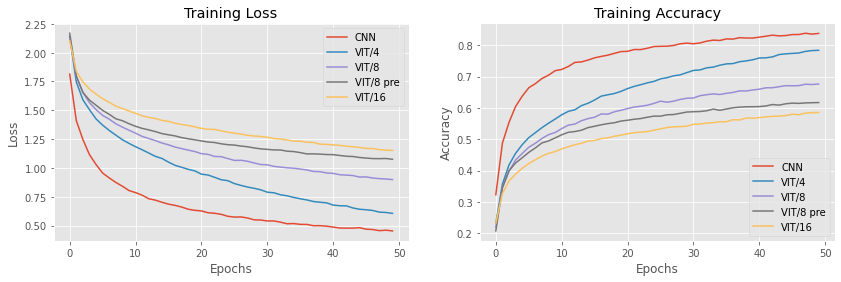

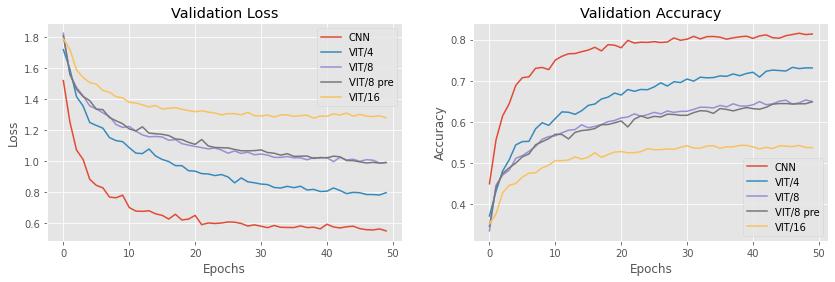

In [36]:
legends = ['CNN', 'VIT/4', 'VIT/8', 'VIT/8 pre', 'VIT/16']
histories = [history_cnn, history_vit_4x4, 
             history_vit_8x8, history_vit_8x8_pre, history_vit_16x16]

plot([i.history['loss'] for i in histories], 
     [i.history['sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Training Loss', 'Training Accuracy'])
plot([i.history['val_loss'] for i in histories], 
     [i.history['val_sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Validation Loss', 'Validation Accuracy'])

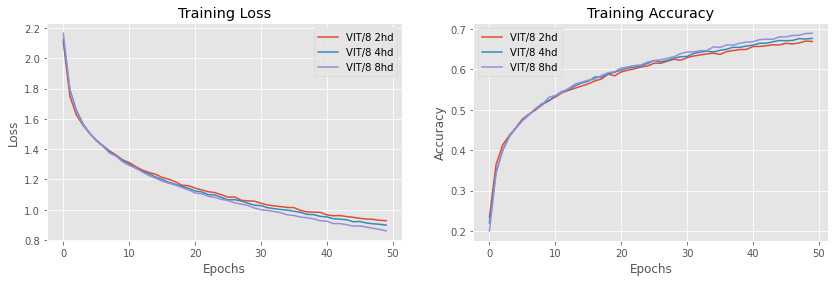

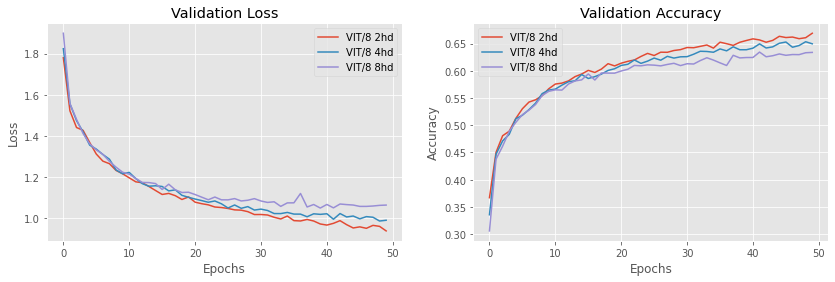

In [37]:
legends = ['VIT/8 2hd', 'VIT/8 4hd', 'VIT/8 8hd']
histories = [history_vit_8x8_2hd, history_vit_8x8, history_vit_8x8_8hd]

plot([i.history['loss'] for i in histories], 
     [i.history['sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Training Loss', 'Training Accuracy'])
plot([i.history['val_loss'] for i in histories], 
     [i.history['val_sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Validation Loss', 'Validation Accuracy'])

**Experiment 8**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 4x4  
Heads : 2

In [38]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=4, 
            projection_dim=32,
            num_layers=4,
            num_heads=2,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_4x4_2hd = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd')

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_10[0][0]                   
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_9 (Patches)             (None, None, 48)     0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 2/50
196/196 [==============================] - 7s 33ms/step - loss: 1.7443 - sparse_categorical_accuracy: 0.3543 - val_loss: 1.4648 - val_sparse_categorical_accuracy: 0.4663


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 3/50
196/196 [==============================] - 6s 32ms/step - loss: 1.5816 - sparse_categorical_accuracy: 0.4226 - val_loss: 1.3649 - val_sparse_categorical_accuracy: 0.4988


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 4/50
196/196 [==============================] - 7s 33ms/step - loss: 1.4859 - sparse_categorical_accuracy: 0.4604 - val_loss: 1.3227 - val_sparse_categorical_accuracy: 0.5231


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 5/50
196/196 [==============================] - 7s 33ms/step - loss: 1.4151 - sparse_categorical_accuracy: 0.4906 - val_loss: 1.2353 - val_sparse_categorical_accuracy: 0.5483


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 6/50
196/196 [==============================] - 7s 33ms/step - loss: 1.3532 - sparse_categorical_accuracy: 0.5136 - val_loss: 1.2127 - val_sparse_categorical_accuracy: 0.5623


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 7/50
196/196 [==============================] - 7s 33ms/step - loss: 1.3073 - sparse_categorical_accuracy: 0.5307 - val_loss: 1.1641 - val_sparse_categorical_accuracy: 0.5735


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 8/50
196/196 [==============================] - 7s 33ms/step - loss: 1.2619 - sparse_categorical_accuracy: 0.5443 - val_loss: 1.1438 - val_sparse_categorical_accuracy: 0.5868


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 9/50
196/196 [==============================] - 7s 33ms/step - loss: 1.2303 - sparse_categorical_accuracy: 0.5566 - val_loss: 1.1161 - val_sparse_categorical_accuracy: 0.5960


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 10/50
196/196 [==============================] - 7s 33ms/step - loss: 1.2011 - sparse_categorical_accuracy: 0.5674 - val_loss: 1.0721 - val_sparse_categorical_accuracy: 0.6166


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 11/50
196/196 [==============================] - 7s 33ms/step - loss: 1.1565 - sparse_categorical_accuracy: 0.5860 - val_loss: 1.0661 - val_sparse_categorical_accuracy: 0.6200


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 12/50
196/196 [==============================] - 7s 33ms/step - loss: 1.1395 - sparse_categorical_accuracy: 0.5940 - val_loss: 1.0470 - val_sparse_categorical_accuracy: 0.6263


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 13/50
196/196 [==============================] - 7s 33ms/step - loss: 1.1101 - sparse_categorical_accuracy: 0.6048 - val_loss: 1.0196 - val_sparse_categorical_accuracy: 0.6423


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 14/50
196/196 [==============================] - 7s 33ms/step - loss: 1.0763 - sparse_categorical_accuracy: 0.6149 - val_loss: 0.9976 - val_sparse_categorical_accuracy: 0.6404
Epoch 15/50
196/196 [==============================] - 7s 33ms/step - loss: 1.0697 - sparse_categorical_accuracy: 0.6183 - val_loss: 0.9736 - val_sparse_categorical_accuracy: 0.6511


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 16/50
196/196 [==============================] - 7s 33ms/step - loss: 1.0324 - sparse_categorical_accuracy: 0.6298 - val_loss: 0.9782 - val_sparse_categorical_accuracy: 0.6503
Epoch 17/50
196/196 [==============================] - 6s 33ms/step - loss: 1.0157 - sparse_categorical_accuracy: 0.6410 - val_loss: 0.9520 - val_sparse_categorical_accuracy: 0.6613


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 18/50
196/196 [==============================] - 7s 33ms/step - loss: 0.9961 - sparse_categorical_accuracy: 0.6451 - val_loss: 0.9373 - val_sparse_categorical_accuracy: 0.6689


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 19/50
196/196 [==============================] - 7s 33ms/step - loss: 0.9798 - sparse_categorical_accuracy: 0.6518 - val_loss: 0.9475 - val_sparse_categorical_accuracy: 0.6665
Epoch 20/50
196/196 [==============================] - 7s 33ms/step - loss: 0.9614 - sparse_categorical_accuracy: 0.6587 - val_loss: 0.9248 - val_sparse_categorical_accuracy: 0.6704


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 21/50
196/196 [==============================] - 7s 33ms/step - loss: 0.9400 - sparse_categorical_accuracy: 0.6638 - val_loss: 0.8994 - val_sparse_categorical_accuracy: 0.6801


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 22/50
196/196 [==============================] - 7s 33ms/step - loss: 0.9317 - sparse_categorical_accuracy: 0.6676 - val_loss: 0.9253 - val_sparse_categorical_accuracy: 0.6709
Epoch 23/50
196/196 [==============================] - 7s 33ms/step - loss: 0.9015 - sparse_categorical_accuracy: 0.6793 - val_loss: 0.8947 - val_sparse_categorical_accuracy: 0.6838


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 24/50
196/196 [==============================] - 7s 34ms/step - loss: 0.8863 - sparse_categorical_accuracy: 0.6852 - val_loss: 0.9033 - val_sparse_categorical_accuracy: 0.6811
Epoch 25/50
196/196 [==============================] - 7s 33ms/step - loss: 0.8753 - sparse_categorical_accuracy: 0.6901 - val_loss: 0.8776 - val_sparse_categorical_accuracy: 0.6909


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 26/50
196/196 [==============================] - 7s 33ms/step - loss: 0.8610 - sparse_categorical_accuracy: 0.6943 - val_loss: 0.8733 - val_sparse_categorical_accuracy: 0.6923


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 27/50
196/196 [==============================] - 7s 33ms/step - loss: 0.8411 - sparse_categorical_accuracy: 0.7013 - val_loss: 0.8744 - val_sparse_categorical_accuracy: 0.6930


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 28/50
196/196 [==============================] - 7s 33ms/step - loss: 0.8299 - sparse_categorical_accuracy: 0.7054 - val_loss: 0.8623 - val_sparse_categorical_accuracy: 0.6990


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 29/50
196/196 [==============================] - 7s 33ms/step - loss: 0.8179 - sparse_categorical_accuracy: 0.7076 - val_loss: 0.8685 - val_sparse_categorical_accuracy: 0.6966
Epoch 30/50
196/196 [==============================] - 7s 33ms/step - loss: 0.8086 - sparse_categorical_accuracy: 0.7103 - val_loss: 0.8465 - val_sparse_categorical_accuracy: 0.7043


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 31/50
196/196 [==============================] - 7s 33ms/step - loss: 0.7832 - sparse_categorical_accuracy: 0.7223 - val_loss: 0.8483 - val_sparse_categorical_accuracy: 0.7022
Epoch 32/50
196/196 [==============================] - 7s 33ms/step - loss: 0.7687 - sparse_categorical_accuracy: 0.7266 - val_loss: 0.8454 - val_sparse_categorical_accuracy: 0.7032
Epoch 33/50
196/196 [==============================] - 7s 33ms/step - loss: 0.7544 - sparse_categorical_accuracy: 0.7332 - val_loss: 0.8490 - val_sparse_categorical_accuracy: 0.7053


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 34/50
196/196 [==============================] - 7s 33ms/step - loss: 0.7524 - sparse_categorical_accuracy: 0.7328 - val_loss: 0.8247 - val_sparse_categorical_accuracy: 0.7141


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 35/50
196/196 [==============================] - 7s 33ms/step - loss: 0.7316 - sparse_categorical_accuracy: 0.7406 - val_loss: 0.8236 - val_sparse_categorical_accuracy: 0.7085
Epoch 36/50
196/196 [==============================] - 7s 34ms/step - loss: 0.7355 - sparse_categorical_accuracy: 0.7389 - val_loss: 0.8144 - val_sparse_categorical_accuracy: 0.7159


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 37/50
196/196 [==============================] - 7s 34ms/step - loss: 0.7175 - sparse_categorical_accuracy: 0.7456 - val_loss: 0.8125 - val_sparse_categorical_accuracy: 0.7137
Epoch 38/50
196/196 [==============================] - 7s 34ms/step - loss: 0.7047 - sparse_categorical_accuracy: 0.7487 - val_loss: 0.7957 - val_sparse_categorical_accuracy: 0.7224


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 39/50
196/196 [==============================] - 7s 33ms/step - loss: 0.6914 - sparse_categorical_accuracy: 0.7503 - val_loss: 0.8060 - val_sparse_categorical_accuracy: 0.7149
Epoch 40/50
196/196 [==============================] - 7s 33ms/step - loss: 0.6902 - sparse_categorical_accuracy: 0.7594 - val_loss: 0.7988 - val_sparse_categorical_accuracy: 0.7243


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 41/50
196/196 [==============================] - 7s 34ms/step - loss: 0.6784 - sparse_categorical_accuracy: 0.7588 - val_loss: 0.8024 - val_sparse_categorical_accuracy: 0.7178
Epoch 42/50
196/196 [==============================] - 7s 33ms/step - loss: 0.6672 - sparse_categorical_accuracy: 0.7616 - val_loss: 0.7840 - val_sparse_categorical_accuracy: 0.7266


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 43/50
196/196 [==============================] - 7s 34ms/step - loss: 0.6636 - sparse_categorical_accuracy: 0.7633 - val_loss: 0.7839 - val_sparse_categorical_accuracy: 0.7262
Epoch 44/50
196/196 [==============================] - 7s 34ms/step - loss: 0.6488 - sparse_categorical_accuracy: 0.7690 - val_loss: 0.7859 - val_sparse_categorical_accuracy: 0.7278


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 45/50
196/196 [==============================] - 7s 33ms/step - loss: 0.6392 - sparse_categorical_accuracy: 0.7758 - val_loss: 0.7867 - val_sparse_categorical_accuracy: 0.7222
Epoch 46/50
196/196 [==============================] - 7s 34ms/step - loss: 0.6341 - sparse_categorical_accuracy: 0.7752 - val_loss: 0.7787 - val_sparse_categorical_accuracy: 0.7291


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 47/50
196/196 [==============================] - 7s 33ms/step - loss: 0.6261 - sparse_categorical_accuracy: 0.7783 - val_loss: 0.7807 - val_sparse_categorical_accuracy: 0.7312


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 48/50
196/196 [==============================] - 7s 34ms/step - loss: 0.6131 - sparse_categorical_accuracy: 0.7840 - val_loss: 0.7814 - val_sparse_categorical_accuracy: 0.7271
Epoch 49/50
196/196 [==============================] - 7s 34ms/step - loss: 0.6033 - sparse_categorical_accuracy: 0.7855 - val_loss: 0.7731 - val_sparse_categorical_accuracy: 0.7300
Epoch 50/50
196/196 [==============================] - 7s 33ms/step - loss: 0.5969 - sparse_categorical_accuracy: 0.7872 - val_loss: 0.7720 - val_sparse_categorical_accuracy: 0.7313


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Total training time 567.0162718296051 seconds


**Experiment 9**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 4x4  
Heads : 8


In [39]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=4, 
            projection_dim=32,
            num_layers=4,
            num_heads=8,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_4x4_8hd = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd')

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_11[0][0]                   
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_10 (Patches)            (None, None, 48)     0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 2/50
196/196 [==============================] - 14s 68ms/step - loss: 1.7963 - sparse_categorical_accuracy: 0.3209 - val_loss: 1.5818 - val_sparse_categorical_accuracy: 0.4297


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 3/50
196/196 [==============================] - 13s 68ms/step - loss: 1.6169 - sparse_categorical_accuracy: 0.4027 - val_loss: 1.4716 - val_sparse_categorical_accuracy: 0.4591


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 4/50
196/196 [==============================] - 13s 68ms/step - loss: 1.5075 - sparse_categorical_accuracy: 0.4469 - val_loss: 1.3079 - val_sparse_categorical_accuracy: 0.5175


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 5/50
196/196 [==============================] - 13s 67ms/step - loss: 1.4198 - sparse_categorical_accuracy: 0.4836 - val_loss: 1.2687 - val_sparse_categorical_accuracy: 0.5418


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 6/50
196/196 [==============================] - 13s 68ms/step - loss: 1.3463 - sparse_categorical_accuracy: 0.5154 - val_loss: 1.2402 - val_sparse_categorical_accuracy: 0.5490


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 7/50
196/196 [==============================] - 13s 67ms/step - loss: 1.3042 - sparse_categorical_accuracy: 0.5261 - val_loss: 1.1898 - val_sparse_categorical_accuracy: 0.5714


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 8/50
196/196 [==============================] - 13s 67ms/step - loss: 1.2657 - sparse_categorical_accuracy: 0.5415 - val_loss: 1.2020 - val_sparse_categorical_accuracy: 0.5621
Epoch 9/50
196/196 [==============================] - 13s 67ms/step - loss: 1.2131 - sparse_categorical_accuracy: 0.5619 - val_loss: 1.1478 - val_sparse_categorical_accuracy: 0.5866


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 10/50
196/196 [==============================] - 13s 67ms/step - loss: 1.1954 - sparse_categorical_accuracy: 0.5693 - val_loss: 1.1228 - val_sparse_categorical_accuracy: 0.6000


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 11/50
196/196 [==============================] - 13s 68ms/step - loss: 1.1521 - sparse_categorical_accuracy: 0.5896 - val_loss: 1.0942 - val_sparse_categorical_accuracy: 0.6071


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 12/50
196/196 [==============================] - 13s 68ms/step - loss: 1.1271 - sparse_categorical_accuracy: 0.5942 - val_loss: 1.1072 - val_sparse_categorical_accuracy: 0.6051
Epoch 13/50
196/196 [==============================] - 13s 68ms/step - loss: 1.0993 - sparse_categorical_accuracy: 0.6082 - val_loss: 1.0895 - val_sparse_categorical_accuracy: 0.6090


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 14/50
196/196 [==============================] - 13s 68ms/step - loss: 1.0993 - sparse_categorical_accuracy: 0.6078 - val_loss: 1.0404 - val_sparse_categorical_accuracy: 0.6256


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 15/50
196/196 [==============================] - 13s 68ms/step - loss: 1.0525 - sparse_categorical_accuracy: 0.6277 - val_loss: 1.0137 - val_sparse_categorical_accuracy: 0.6400


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 16/50
196/196 [==============================] - 13s 68ms/step - loss: 1.0341 - sparse_categorical_accuracy: 0.6337 - val_loss: 1.0435 - val_sparse_categorical_accuracy: 0.6305
Epoch 17/50
196/196 [==============================] - 13s 67ms/step - loss: 1.0168 - sparse_categorical_accuracy: 0.6362 - val_loss: 1.0086 - val_sparse_categorical_accuracy: 0.6358
Epoch 18/50
196/196 [==============================] - 13s 67ms/step - loss: 1.0120 - sparse_categorical_accuracy: 0.6383 - val_loss: 1.0090 - val_sparse_categorical_accuracy: 0.6387
Epoch 19/50
196/196 [==============================] - 13s 68ms/step - loss: 0.9656 - sparse_categorical_accuracy: 0.6542 - val_loss: 1.0002 - val_sparse_categorical_accuracy: 0.6398
Epoch 20/50
196/196 [==============================] - 13s 68ms/step - loss: 0.9535 - sparse_categorical_accuracy: 0.6575 - val_loss: 0.9921 - val_sparse_categorical_accuracy: 0.6432


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 21/50
196/196 [==============================] - 13s 68ms/step - loss: 0.9393 - sparse_categorical_accuracy: 0.6629 - val_loss: 0.9908 - val_sparse_categorical_accuracy: 0.6455


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 22/50
196/196 [==============================] - 13s 68ms/step - loss: 0.9200 - sparse_categorical_accuracy: 0.6713 - val_loss: 0.9860 - val_sparse_categorical_accuracy: 0.6512


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 23/50
196/196 [==============================] - 13s 68ms/step - loss: 0.9079 - sparse_categorical_accuracy: 0.6768 - val_loss: 0.9611 - val_sparse_categorical_accuracy: 0.6568


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 24/50
196/196 [==============================] - 13s 68ms/step - loss: 0.8827 - sparse_categorical_accuracy: 0.6864 - val_loss: 0.9604 - val_sparse_categorical_accuracy: 0.6564
Epoch 25/50
196/196 [==============================] - 13s 67ms/step - loss: 0.8634 - sparse_categorical_accuracy: 0.6908 - val_loss: 0.9713 - val_sparse_categorical_accuracy: 0.6512
Epoch 26/50
196/196 [==============================] - 13s 68ms/step - loss: 0.8638 - sparse_categorical_accuracy: 0.6921 - val_loss: 0.9394 - val_sparse_categorical_accuracy: 0.6627


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 27/50
196/196 [==============================] - 13s 68ms/step - loss: 0.8482 - sparse_categorical_accuracy: 0.6976 - val_loss: 0.9456 - val_sparse_categorical_accuracy: 0.6631


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 28/50
196/196 [==============================] - 13s 68ms/step - loss: 0.8282 - sparse_categorical_accuracy: 0.7048 - val_loss: 0.9413 - val_sparse_categorical_accuracy: 0.6665


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 29/50
196/196 [==============================] - 13s 68ms/step - loss: 0.8146 - sparse_categorical_accuracy: 0.7121 - val_loss: 0.9135 - val_sparse_categorical_accuracy: 0.6742


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 30/50
196/196 [==============================] - 13s 68ms/step - loss: 0.7979 - sparse_categorical_accuracy: 0.7146 - val_loss: 0.9225 - val_sparse_categorical_accuracy: 0.6741
Epoch 31/50
196/196 [==============================] - 13s 68ms/step - loss: 0.7820 - sparse_categorical_accuracy: 0.7185 - val_loss: 0.9159 - val_sparse_categorical_accuracy: 0.6759


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 32/50
196/196 [==============================] - 13s 68ms/step - loss: 0.7693 - sparse_categorical_accuracy: 0.7246 - val_loss: 0.9230 - val_sparse_categorical_accuracy: 0.6667
Epoch 33/50
196/196 [==============================] - 13s 68ms/step - loss: 0.7669 - sparse_categorical_accuracy: 0.7281 - val_loss: 0.9042 - val_sparse_categorical_accuracy: 0.6753
Epoch 34/50
196/196 [==============================] - 13s 68ms/step - loss: 0.7575 - sparse_categorical_accuracy: 0.7277 - val_loss: 0.9227 - val_sparse_categorical_accuracy: 0.6750
Epoch 35/50
196/196 [==============================] - 13s 68ms/step - loss: 0.7313 - sparse_categorical_accuracy: 0.7371 - val_loss: 0.9109 - val_sparse_categorical_accuracy: 0.6774


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 36/50
196/196 [==============================] - 14s 68ms/step - loss: 0.7242 - sparse_categorical_accuracy: 0.7413 - val_loss: 0.9257 - val_sparse_categorical_accuracy: 0.6766
Epoch 37/50
196/196 [==============================] - 14s 69ms/step - loss: 0.7084 - sparse_categorical_accuracy: 0.7446 - val_loss: 0.9150 - val_sparse_categorical_accuracy: 0.6802


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 38/50
196/196 [==============================] - 13s 68ms/step - loss: 0.6944 - sparse_categorical_accuracy: 0.7527 - val_loss: 0.8940 - val_sparse_categorical_accuracy: 0.6833


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 39/50
196/196 [==============================] - 13s 68ms/step - loss: 0.6880 - sparse_categorical_accuracy: 0.7532 - val_loss: 0.9248 - val_sparse_categorical_accuracy: 0.6739
Epoch 40/50
196/196 [==============================] - 13s 68ms/step - loss: 0.6754 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.8927 - val_sparse_categorical_accuracy: 0.6854


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 41/50
196/196 [==============================] - 13s 68ms/step - loss: 0.6648 - sparse_categorical_accuracy: 0.7620 - val_loss: 0.9032 - val_sparse_categorical_accuracy: 0.6811
Epoch 42/50
196/196 [==============================] - 13s 68ms/step - loss: 0.6580 - sparse_categorical_accuracy: 0.7662 - val_loss: 0.8974 - val_sparse_categorical_accuracy: 0.6875


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 43/50
196/196 [==============================] - 13s 68ms/step - loss: 0.6447 - sparse_categorical_accuracy: 0.7690 - val_loss: 0.9123 - val_sparse_categorical_accuracy: 0.6793
Epoch 44/50
196/196 [==============================] - 13s 68ms/step - loss: 0.6537 - sparse_categorical_accuracy: 0.7650 - val_loss: 0.8858 - val_sparse_categorical_accuracy: 0.6908


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 45/50
196/196 [==============================] - 13s 68ms/step - loss: 0.6223 - sparse_categorical_accuracy: 0.7753 - val_loss: 0.8995 - val_sparse_categorical_accuracy: 0.6906
Epoch 46/50
196/196 [==============================] - 13s 68ms/step - loss: 0.6211 - sparse_categorical_accuracy: 0.7756 - val_loss: 0.8937 - val_sparse_categorical_accuracy: 0.6934


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 47/50
196/196 [==============================] - 13s 68ms/step - loss: 0.6193 - sparse_categorical_accuracy: 0.7781 - val_loss: 0.9084 - val_sparse_categorical_accuracy: 0.6882
Epoch 48/50
196/196 [==============================] - 14s 69ms/step - loss: 0.6053 - sparse_categorical_accuracy: 0.7798 - val_loss: 0.8963 - val_sparse_categorical_accuracy: 0.6932
Epoch 49/50
196/196 [==============================] - 13s 68ms/step - loss: 0.5848 - sparse_categorical_accuracy: 0.7906 - val_loss: 0.8827 - val_sparse_categorical_accuracy: 0.6956


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 50/50
196/196 [==============================] - 14s 69ms/step - loss: 0.5821 - sparse_categorical_accuracy: 0.7905 - val_loss: 0.9117 - val_sparse_categorical_accuracy: 0.6890
Total training time 878.7844672203064 seconds


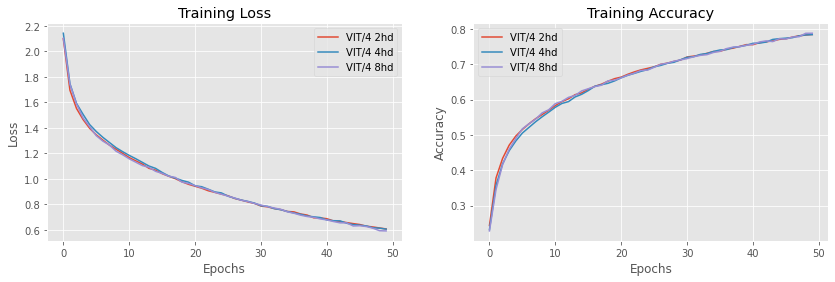

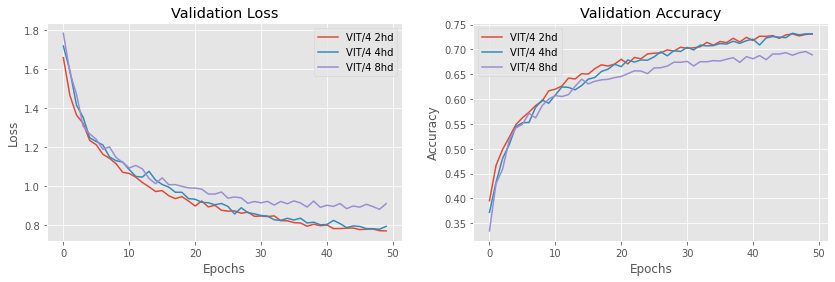

In [40]:
legends = ['VIT/4 2hd', 'VIT/4 4hd', 'VIT/4 8hd']
histories = [history_vit_4x4_2hd, history_vit_4x4, history_vit_4x4_8hd]

plot([i.history['loss'] for i in histories], 
     [i.history['sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Training Loss', 'Training Accuracy'])
plot([i.history['val_loss'] for i in histories], 
     [i.history['val_sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Validation Loss', 'Validation Accuracy'])

**Experiment 10**  
Model : VIT  
Preprocessing : False  
Batch size : 512  
Patch : 4x4  
Heads : 2


In [41]:
batch_size = 512
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=4, 
            projection_dim=32,
            num_layers=4,
            num_heads=2,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_4x4_2hd_bs512 = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512')

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_12[0][0]                   
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_11 (Patches)            (None, None, 48)     0           resize[0][0]                     
___________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 2/50
98/98 [==============================] - 6s 61ms/step - loss: 1.8930 - sparse_categorical_accuracy: 0.3072 - val_loss: 1.6139 - val_sparse_categorical_accuracy: 0.4105


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 3/50
98/98 [==============================] - 6s 61ms/step - loss: 1.7008 - sparse_categorical_accuracy: 0.3755 - val_loss: 1.4793 - val_sparse_categorical_accuracy: 0.4594


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 4/50
98/98 [==============================] - 6s 61ms/step - loss: 1.5840 - sparse_categorical_accuracy: 0.4234 - val_loss: 1.3571 - val_sparse_categorical_accuracy: 0.5066


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 5/50
98/98 [==============================] - 6s 61ms/step - loss: 1.4740 - sparse_categorical_accuracy: 0.4616 - val_loss: 1.3287 - val_sparse_categorical_accuracy: 0.5138


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 6/50
98/98 [==============================] - 6s 61ms/step - loss: 1.4289 - sparse_categorical_accuracy: 0.4763 - val_loss: 1.2409 - val_sparse_categorical_accuracy: 0.5455


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 7/50
98/98 [==============================] - 6s 62ms/step - loss: 1.3776 - sparse_categorical_accuracy: 0.4988 - val_loss: 1.2095 - val_sparse_categorical_accuracy: 0.5601


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 8/50
98/98 [==============================] - 6s 62ms/step - loss: 1.3334 - sparse_categorical_accuracy: 0.5153 - val_loss: 1.1913 - val_sparse_categorical_accuracy: 0.5661


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 9/50
98/98 [==============================] - 6s 62ms/step - loss: 1.2924 - sparse_categorical_accuracy: 0.5337 - val_loss: 1.1614 - val_sparse_categorical_accuracy: 0.5815


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 10/50
98/98 [==============================] - 6s 62ms/step - loss: 1.2689 - sparse_categorical_accuracy: 0.5443 - val_loss: 1.1330 - val_sparse_categorical_accuracy: 0.5907


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 11/50
98/98 [==============================] - 6s 62ms/step - loss: 1.2258 - sparse_categorical_accuracy: 0.5607 - val_loss: 1.1053 - val_sparse_categorical_accuracy: 0.6020


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 12/50
98/98 [==============================] - 6s 62ms/step - loss: 1.1919 - sparse_categorical_accuracy: 0.5722 - val_loss: 1.0793 - val_sparse_categorical_accuracy: 0.6077


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 13/50
98/98 [==============================] - 6s 61ms/step - loss: 1.1726 - sparse_categorical_accuracy: 0.5781 - val_loss: 1.0575 - val_sparse_categorical_accuracy: 0.6210


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 14/50
98/98 [==============================] - 6s 62ms/step - loss: 1.1531 - sparse_categorical_accuracy: 0.5873 - val_loss: 1.0481 - val_sparse_categorical_accuracy: 0.6236


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 15/50
98/98 [==============================] - 6s 62ms/step - loss: 1.1210 - sparse_categorical_accuracy: 0.5967 - val_loss: 1.0233 - val_sparse_categorical_accuracy: 0.6365


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 16/50
98/98 [==============================] - 6s 62ms/step - loss: 1.0910 - sparse_categorical_accuracy: 0.6108 - val_loss: 1.0032 - val_sparse_categorical_accuracy: 0.6401


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 17/50
98/98 [==============================] - 6s 61ms/step - loss: 1.0767 - sparse_categorical_accuracy: 0.6155 - val_loss: 1.0017 - val_sparse_categorical_accuracy: 0.6383
Epoch 18/50
98/98 [==============================] - 6s 61ms/step - loss: 1.0560 - sparse_categorical_accuracy: 0.6241 - val_loss: 0.9727 - val_sparse_categorical_accuracy: 0.6500


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 19/50
98/98 [==============================] - 6s 62ms/step - loss: 1.0160 - sparse_categorical_accuracy: 0.6360 - val_loss: 0.9675 - val_sparse_categorical_accuracy: 0.6504


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 20/50
98/98 [==============================] - 6s 62ms/step - loss: 1.0131 - sparse_categorical_accuracy: 0.6420 - val_loss: 0.9388 - val_sparse_categorical_accuracy: 0.6623


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 21/50
98/98 [==============================] - 6s 61ms/step - loss: 0.9934 - sparse_categorical_accuracy: 0.6431 - val_loss: 0.9429 - val_sparse_categorical_accuracy: 0.6602
Epoch 22/50
98/98 [==============================] - 6s 61ms/step - loss: 0.9784 - sparse_categorical_accuracy: 0.6494 - val_loss: 0.9363 - val_sparse_categorical_accuracy: 0.6639


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 23/50
98/98 [==============================] - 6s 61ms/step - loss: 0.9546 - sparse_categorical_accuracy: 0.6608 - val_loss: 0.9335 - val_sparse_categorical_accuracy: 0.6717


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 24/50
98/98 [==============================] - 6s 61ms/step - loss: 0.9338 - sparse_categorical_accuracy: 0.6686 - val_loss: 0.9267 - val_sparse_categorical_accuracy: 0.6700
Epoch 25/50
98/98 [==============================] - 6s 61ms/step - loss: 0.9375 - sparse_categorical_accuracy: 0.6661 - val_loss: 0.9039 - val_sparse_categorical_accuracy: 0.6751


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 26/50
98/98 [==============================] - 6s 61ms/step - loss: 0.8915 - sparse_categorical_accuracy: 0.6847 - val_loss: 0.8966 - val_sparse_categorical_accuracy: 0.6834


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 27/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8939 - sparse_categorical_accuracy: 0.6811 - val_loss: 0.9013 - val_sparse_categorical_accuracy: 0.6783
Epoch 28/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8797 - sparse_categorical_accuracy: 0.6830 - val_loss: 0.8930 - val_sparse_categorical_accuracy: 0.6820
Epoch 29/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8642 - sparse_categorical_accuracy: 0.6946 - val_loss: 0.8840 - val_sparse_categorical_accuracy: 0.6884


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 30/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8583 - sparse_categorical_accuracy: 0.6952 - val_loss: 0.8943 - val_sparse_categorical_accuracy: 0.6785
Epoch 31/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8333 - sparse_categorical_accuracy: 0.7053 - val_loss: 0.8772 - val_sparse_categorical_accuracy: 0.6868
Epoch 32/50
98/98 [==============================] - 6s 61ms/step - loss: 0.8212 - sparse_categorical_accuracy: 0.7100 - val_loss: 0.8609 - val_sparse_categorical_accuracy: 0.6890


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 33/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8105 - sparse_categorical_accuracy: 0.7092 - val_loss: 0.8546 - val_sparse_categorical_accuracy: 0.6976


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 34/50
98/98 [==============================] - 6s 63ms/step - loss: 0.7990 - sparse_categorical_accuracy: 0.7139 - val_loss: 0.8521 - val_sparse_categorical_accuracy: 0.7021


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 35/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7807 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.8471 - val_sparse_categorical_accuracy: 0.7030


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 36/50
98/98 [==============================] - 6s 63ms/step - loss: 0.7674 - sparse_categorical_accuracy: 0.7277 - val_loss: 0.8333 - val_sparse_categorical_accuracy: 0.7036


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 37/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7653 - sparse_categorical_accuracy: 0.7274 - val_loss: 0.8370 - val_sparse_categorical_accuracy: 0.7043


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 38/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7466 - sparse_categorical_accuracy: 0.7312 - val_loss: 0.8419 - val_sparse_categorical_accuracy: 0.7006
Epoch 39/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7508 - sparse_categorical_accuracy: 0.7296 - val_loss: 0.8172 - val_sparse_categorical_accuracy: 0.7101


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 40/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7466 - sparse_categorical_accuracy: 0.7339 - val_loss: 0.8142 - val_sparse_categorical_accuracy: 0.7142


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 41/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7367 - sparse_categorical_accuracy: 0.7351 - val_loss: 0.8096 - val_sparse_categorical_accuracy: 0.7145


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 42/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7249 - sparse_categorical_accuracy: 0.7448 - val_loss: 0.8199 - val_sparse_categorical_accuracy: 0.7145
Epoch 43/50
98/98 [==============================] - 6s 61ms/step - loss: 0.7044 - sparse_categorical_accuracy: 0.7522 - val_loss: 0.8117 - val_sparse_categorical_accuracy: 0.7162


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 44/50
98/98 [==============================] - 6s 62ms/step - loss: 0.6962 - sparse_categorical_accuracy: 0.7523 - val_loss: 0.8137 - val_sparse_categorical_accuracy: 0.7201


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 45/50
98/98 [==============================] - 6s 63ms/step - loss: 0.7004 - sparse_categorical_accuracy: 0.7514 - val_loss: 0.8141 - val_sparse_categorical_accuracy: 0.7166
Epoch 46/50
98/98 [==============================] - 6s 63ms/step - loss: 0.6911 - sparse_categorical_accuracy: 0.7507 - val_loss: 0.7924 - val_sparse_categorical_accuracy: 0.7200
Epoch 47/50
98/98 [==============================] - 6s 62ms/step - loss: 0.6803 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.7992 - val_sparse_categorical_accuracy: 0.7241


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 48/50
98/98 [==============================] - 6s 62ms/step - loss: 0.6708 - sparse_categorical_accuracy: 0.7618 - val_loss: 0.8021 - val_sparse_categorical_accuracy: 0.7181
Epoch 49/50
98/98 [==============================] - 6s 62ms/step - loss: 0.6724 - sparse_categorical_accuracy: 0.7636 - val_loss: 0.7923 - val_sparse_categorical_accuracy: 0.7256


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 50/50
98/98 [==============================] - 6s 62ms/step - loss: 0.6478 - sparse_categorical_accuracy: 0.7684 - val_loss: 0.8055 - val_sparse_categorical_accuracy: 0.7202
Total training time 564.9703493118286 seconds


**Experiment 11**  
Model : VIT  
Preprocessing : False  
Batch size : 1024  
Patch : 4x4  
Heads : 2


In [42]:
batch_size = 1024
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=4, 
            projection_dim=32,
            num_layers=4,
            num_heads=2,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_4x4_2hd_bs1024 = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024')

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_13[0][0]                   
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_12 (Patches)            (None, None, 48)     0           resize[0][0]                     
___________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 2/50
49/49 [==============================] - 6s 114ms/step - loss: 2.0880 - sparse_categorical_accuracy: 0.2174 - val_loss: 1.8740 - val_sparse_categorical_accuracy: 0.3185


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 3/50
49/49 [==============================] - 6s 113ms/step - loss: 1.9509 - sparse_categorical_accuracy: 0.2796 - val_loss: 1.7045 - val_sparse_categorical_accuracy: 0.3782


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 4/50
49/49 [==============================] - 6s 113ms/step - loss: 1.8104 - sparse_categorical_accuracy: 0.3338 - val_loss: 1.5816 - val_sparse_categorical_accuracy: 0.4215


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 5/50
49/49 [==============================] - 6s 113ms/step - loss: 1.7141 - sparse_categorical_accuracy: 0.3698 - val_loss: 1.4811 - val_sparse_categorical_accuracy: 0.4586


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 6/50
49/49 [==============================] - 6s 113ms/step - loss: 1.6063 - sparse_categorical_accuracy: 0.4085 - val_loss: 1.4210 - val_sparse_categorical_accuracy: 0.4832


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 7/50
49/49 [==============================] - 6s 113ms/step - loss: 1.5533 - sparse_categorical_accuracy: 0.4326 - val_loss: 1.3791 - val_sparse_categorical_accuracy: 0.5009


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 8/50
49/49 [==============================] - 6s 113ms/step - loss: 1.5119 - sparse_categorical_accuracy: 0.4494 - val_loss: 1.3330 - val_sparse_categorical_accuracy: 0.5174


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 9/50
49/49 [==============================] - 6s 113ms/step - loss: 1.4675 - sparse_categorical_accuracy: 0.4721 - val_loss: 1.3183 - val_sparse_categorical_accuracy: 0.5204


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 10/50
49/49 [==============================] - 6s 113ms/step - loss: 1.4294 - sparse_categorical_accuracy: 0.4819 - val_loss: 1.2892 - val_sparse_categorical_accuracy: 0.5278


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 11/50
49/49 [==============================] - 6s 113ms/step - loss: 1.3918 - sparse_categorical_accuracy: 0.4932 - val_loss: 1.2605 - val_sparse_categorical_accuracy: 0.5396


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 12/50
49/49 [==============================] - 6s 113ms/step - loss: 1.3616 - sparse_categorical_accuracy: 0.5069 - val_loss: 1.2254 - val_sparse_categorical_accuracy: 0.5527


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 13/50
49/49 [==============================] - 6s 113ms/step - loss: 1.3326 - sparse_categorical_accuracy: 0.5202 - val_loss: 1.2202 - val_sparse_categorical_accuracy: 0.5554


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 14/50
49/49 [==============================] - 6s 113ms/step - loss: 1.3084 - sparse_categorical_accuracy: 0.5299 - val_loss: 1.1829 - val_sparse_categorical_accuracy: 0.5693


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 15/50
49/49 [==============================] - 6s 114ms/step - loss: 1.2823 - sparse_categorical_accuracy: 0.5384 - val_loss: 1.1814 - val_sparse_categorical_accuracy: 0.5736


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 16/50
49/49 [==============================] - 6s 114ms/step - loss: 1.2468 - sparse_categorical_accuracy: 0.5521 - val_loss: 1.1415 - val_sparse_categorical_accuracy: 0.5888


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 17/50
49/49 [==============================] - 6s 113ms/step - loss: 1.2203 - sparse_categorical_accuracy: 0.5618 - val_loss: 1.1262 - val_sparse_categorical_accuracy: 0.5970


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 18/50
49/49 [==============================] - 6s 113ms/step - loss: 1.2074 - sparse_categorical_accuracy: 0.5685 - val_loss: 1.1096 - val_sparse_categorical_accuracy: 0.6015


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 19/50
49/49 [==============================] - 6s 113ms/step - loss: 1.1858 - sparse_categorical_accuracy: 0.5753 - val_loss: 1.0867 - val_sparse_categorical_accuracy: 0.6073


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 20/50
49/49 [==============================] - 6s 113ms/step - loss: 1.1615 - sparse_categorical_accuracy: 0.5780 - val_loss: 1.0805 - val_sparse_categorical_accuracy: 0.6098


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 21/50
49/49 [==============================] - 6s 112ms/step - loss: 1.1531 - sparse_categorical_accuracy: 0.5885 - val_loss: 1.0693 - val_sparse_categorical_accuracy: 0.6159


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 22/50
49/49 [==============================] - 6s 113ms/step - loss: 1.1279 - sparse_categorical_accuracy: 0.5972 - val_loss: 1.0721 - val_sparse_categorical_accuracy: 0.6133
Epoch 23/50
49/49 [==============================] - 6s 113ms/step - loss: 1.1146 - sparse_categorical_accuracy: 0.6008 - val_loss: 1.0421 - val_sparse_categorical_accuracy: 0.6255


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 24/50
49/49 [==============================] - 6s 113ms/step - loss: 1.0923 - sparse_categorical_accuracy: 0.6088 - val_loss: 1.0225 - val_sparse_categorical_accuracy: 0.6346


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 25/50
49/49 [==============================] - 6s 113ms/step - loss: 1.0776 - sparse_categorical_accuracy: 0.6158 - val_loss: 1.0327 - val_sparse_categorical_accuracy: 0.6361


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 26/50
49/49 [==============================] - 6s 113ms/step - loss: 1.0565 - sparse_categorical_accuracy: 0.6249 - val_loss: 1.0089 - val_sparse_categorical_accuracy: 0.6402


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 27/50
49/49 [==============================] - 6s 113ms/step - loss: 1.0463 - sparse_categorical_accuracy: 0.6270 - val_loss: 0.9833 - val_sparse_categorical_accuracy: 0.6491


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 28/50
49/49 [==============================] - 6s 113ms/step - loss: 1.0307 - sparse_categorical_accuracy: 0.6333 - val_loss: 0.9697 - val_sparse_categorical_accuracy: 0.6540


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 29/50
49/49 [==============================] - 6s 114ms/step - loss: 1.0187 - sparse_categorical_accuracy: 0.6411 - val_loss: 0.9606 - val_sparse_categorical_accuracy: 0.6554


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 30/50
49/49 [==============================] - 6s 114ms/step - loss: 1.0015 - sparse_categorical_accuracy: 0.6461 - val_loss: 0.9499 - val_sparse_categorical_accuracy: 0.6556


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 31/50
49/49 [==============================] - 6s 114ms/step - loss: 0.9854 - sparse_categorical_accuracy: 0.6472 - val_loss: 0.9571 - val_sparse_categorical_accuracy: 0.6627


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 32/50
49/49 [==============================] - 6s 114ms/step - loss: 0.9707 - sparse_categorical_accuracy: 0.6516 - val_loss: 0.9483 - val_sparse_categorical_accuracy: 0.6625
Epoch 33/50
49/49 [==============================] - 6s 114ms/step - loss: 0.9626 - sparse_categorical_accuracy: 0.6584 - val_loss: 0.9405 - val_sparse_categorical_accuracy: 0.6688


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 34/50
49/49 [==============================] - 6s 113ms/step - loss: 0.9445 - sparse_categorical_accuracy: 0.6657 - val_loss: 0.9316 - val_sparse_categorical_accuracy: 0.6664
Epoch 35/50
49/49 [==============================] - 6s 114ms/step - loss: 0.9333 - sparse_categorical_accuracy: 0.6692 - val_loss: 0.9214 - val_sparse_categorical_accuracy: 0.6757


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 36/50
49/49 [==============================] - 6s 114ms/step - loss: 0.9099 - sparse_categorical_accuracy: 0.6760 - val_loss: 0.9247 - val_sparse_categorical_accuracy: 0.6714
Epoch 37/50
49/49 [==============================] - 6s 114ms/step - loss: 0.9132 - sparse_categorical_accuracy: 0.6748 - val_loss: 0.9111 - val_sparse_categorical_accuracy: 0.6770


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 38/50
49/49 [==============================] - 6s 114ms/step - loss: 0.8866 - sparse_categorical_accuracy: 0.6833 - val_loss: 0.9191 - val_sparse_categorical_accuracy: 0.6749
Epoch 39/50
49/49 [==============================] - 6s 113ms/step - loss: 0.8841 - sparse_categorical_accuracy: 0.6855 - val_loss: 0.9016 - val_sparse_categorical_accuracy: 0.6778


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 40/50
49/49 [==============================] - 6s 114ms/step - loss: 0.8671 - sparse_categorical_accuracy: 0.6925 - val_loss: 0.8965 - val_sparse_categorical_accuracy: 0.6880


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 41/50
49/49 [==============================] - 6s 113ms/step - loss: 0.8506 - sparse_categorical_accuracy: 0.6983 - val_loss: 0.8813 - val_sparse_categorical_accuracy: 0.6902


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 42/50
49/49 [==============================] - 6s 114ms/step - loss: 0.8426 - sparse_categorical_accuracy: 0.7001 - val_loss: 0.8800 - val_sparse_categorical_accuracy: 0.6935


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 43/50
49/49 [==============================] - 6s 114ms/step - loss: 0.8357 - sparse_categorical_accuracy: 0.6992 - val_loss: 0.8778 - val_sparse_categorical_accuracy: 0.6888
Epoch 44/50
49/49 [==============================] - 6s 114ms/step - loss: 0.8299 - sparse_categorical_accuracy: 0.7036 - val_loss: 0.8652 - val_sparse_categorical_accuracy: 0.6937


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 45/50
49/49 [==============================] - 6s 113ms/step - loss: 0.8127 - sparse_categorical_accuracy: 0.7107 - val_loss: 0.8707 - val_sparse_categorical_accuracy: 0.6958


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 46/50
49/49 [==============================] - 6s 114ms/step - loss: 0.8067 - sparse_categorical_accuracy: 0.7099 - val_loss: 0.8644 - val_sparse_categorical_accuracy: 0.6959


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 47/50
49/49 [==============================] - 6s 114ms/step - loss: 0.8036 - sparse_categorical_accuracy: 0.7146 - val_loss: 0.8620 - val_sparse_categorical_accuracy: 0.6968


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 48/50
49/49 [==============================] - 6s 114ms/step - loss: 0.7775 - sparse_categorical_accuracy: 0.7203 - val_loss: 0.8582 - val_sparse_categorical_accuracy: 0.7001


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 49/50
49/49 [==============================] - 6s 113ms/step - loss: 0.7797 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.8692 - val_sparse_categorical_accuracy: 0.6953
Epoch 50/50
49/49 [==============================] - 6s 113ms/step - loss: 0.7789 - sparse_categorical_accuracy: 0.7245 - val_loss: 0.8501 - val_sparse_categorical_accuracy: 0.6973
Total training time 573.5337846279144 seconds


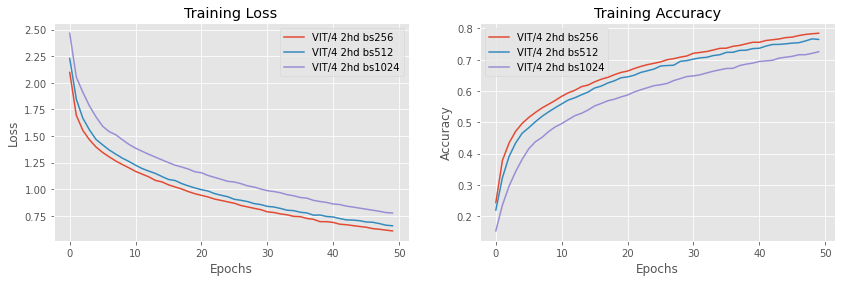

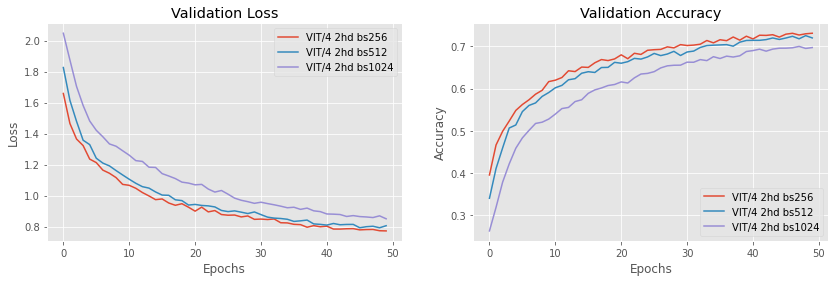

In [43]:
legends = ['VIT/4 2hd bs256', 'VIT/4 2hd bs512', 'VIT/4 2hd bs1024']
histories = [history_vit_4x4_2hd, history_vit_4x4_2hd_bs512, history_vit_4x4_2hd_bs1024]

plot([i.history['loss'] for i in histories], 
     [i.history['sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Training Loss', 'Training Accuracy'])
plot([i.history['val_loss'] for i in histories], 
     [i.history['val_sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Validation Loss', 'Validation Accuracy'])

**Experiment 12**  
Model : CNN  
Preprocessing : False  
Batch size : 256  
Epochs: 500

In [44]:
batch_size = 256
epochs = 500
model = SmallCNN(num_classes=num_classes, 
                 image_height=image_height, 
                 image_width=image_width,
                 preprocess=False).model()
model.summary()
history_cnn_500epoch = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch')

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropout)              (None, 14, 14, 32)        0  

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 2/500
196/196 [==============================] - 3s 17ms/step - loss: 1.3963 - sparse_categorical_accuracy: 0.4920 - val_loss: 1.1811 - val_sparse_categorical_accuracy: 0.5776
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 3/500
196/196 [==============================] - 3s 17ms/step - loss: 1.2254 - sparse_categorical_accuracy: 0.5608 - val_loss: 1.0603 - val_sparse_categorical_accuracy: 0.6320
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 4/500
196/196 [==============================] - 3s 17ms/step - loss: 1.1143 - sparse_categorical_accuracy: 0.6067 - val_loss: 0.9705 - val_sparse_categorical_accuracy: 0.6611
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 5/500
196/196 [==============================] - 3s 17ms/step - loss: 1.0113 - sparse_categorical_accuracy: 0.6436 - val_loss: 0.8857 - val_sparse_categorical_accuracy: 0.6918
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 6/500
196/196 [==============================] - 3s 17ms/step - loss: 0.9291 - sparse_categorical_accuracy: 0.6717 - val_loss: 0.8349 - val_sparse_categorical_accuracy: 0.7061
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 7/500
196/196 [==============================] - 3s 17ms/step - loss: 0.8839 - sparse_categorical_accuracy: 0.6904 - val_loss: 0.7921 - val_sparse_categorical_accuracy: 0.7290
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 8/500
196/196 [==============================] - 4s 18ms/step - loss: 0.8491 - sparse_categorical_accuracy: 0.7029 - val_loss: 0.7547 - val_sparse_categorical_accuracy: 0.7417
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 9/500
196/196 [==============================] - 4s 18ms/step - loss: 0.7989 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.7294 - val_sparse_categorical_accuracy: 0.7444
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 10/500
196/196 [==============================] - 4s 18ms/step - loss: 0.7802 - sparse_categorical_accuracy: 0.7285 - val_loss: 0.7156 - val_sparse_categorical_accuracy: 0.7511
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 11/500
196/196 [==============================] - 4s 18ms/step - loss: 0.7476 - sparse_categorical_accuracy: 0.7399 - val_loss: 0.6930 - val_sparse_categorical_accuracy: 0.7649
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 12/500
196/196 [==============================] - 4s 18ms/step - loss: 0.7328 - sparse_categorical_accuracy: 0.7424 - val_loss: 0.6667 - val_sparse_categorical_accuracy: 0.7695
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 13/500
196/196 [==============================] - 4s 18ms/step - loss: 0.7097 - sparse_categorical_accuracy: 0.7525 - val_loss: 0.6598 - val_sparse_categorical_accuracy: 0.7740
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 14/500
196/196 [==============================] - 4s 18ms/step - loss: 0.6888 - sparse_categorical_accuracy: 0.7567 - val_loss: 0.6423 - val_sparse_categorical_accuracy: 0.7796
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 15/500
196/196 [==============================] - 4s 18ms/step - loss: 0.6711 - sparse_categorical_accuracy: 0.7646 - val_loss: 0.6460 - val_sparse_categorical_accuracy: 0.7748
Epoch 16/500
196/196 [==============================] - 4s 18ms/step - loss: 0.6510 - sparse_categorical_accuracy: 0.7712 - val_loss: 0.6274 - val_sparse_categorical_accuracy: 0.7854
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 17/500
196/196 [==============================] - 4s 18ms/step - loss: 0.6368 - sparse_categorical_accuracy: 0.7747 - val_loss: 0.6228 - val_sparse_categorical_accuracy: 0.7857
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 18/500
196/196 [==============================] - 4s 18ms/step - loss: 0.6340 - sparse_categorical_accuracy: 0.7768 - val_loss: 0.6123 - val_sparse_categorical_accuracy: 0.7925
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 19/500
196/196 [==============================] - 4s 18ms/step - loss: 0.6074 - sparse_categorical_accuracy: 0.7874 - val_loss: 0.6036 - val_sparse_categorical_accuracy: 0.7934
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 20/500
196/196 [==============================] - 4s 18ms/step - loss: 0.6032 - sparse_categorical_accuracy: 0.7905 - val_loss: 0.5909 - val_sparse_categorical_accuracy: 0.7975
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 21/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5918 - sparse_categorical_accuracy: 0.7932 - val_loss: 0.5929 - val_sparse_categorical_accuracy: 0.7954
Epoch 22/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5893 - sparse_categorical_accuracy: 0.7915 - val_loss: 0.6070 - val_sparse_categorical_accuracy: 0.7936
Epoch 23/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5829 - sparse_categorical_accuracy: 0.7960 - val_loss: 0.5957 - val_sparse_categorical_accuracy: 0.7949
Epoch 24/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5676 - sparse_categorical_accuracy: 0.8011 - val_loss: 0.5975 - val_sparse_categorical_accuracy: 0.7961
Epoch 25/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5537 - sparse_categorical_accuracy: 0.8035 - val_loss: 0.5845 - val_sparse_categorical_accuracy: 0.8011
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-T

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 26/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5432 - sparse_categorical_accuracy: 0.8074 - val_loss: 0.5764 - val_sparse_categorical_accuracy: 0.8028
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 27/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5323 - sparse_categorical_accuracy: 0.8101 - val_loss: 0.5700 - val_sparse_categorical_accuracy: 0.8075
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 28/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5350 - sparse_categorical_accuracy: 0.8105 - val_loss: 0.5725 - val_sparse_categorical_accuracy: 0.8050
Epoch 29/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5197 - sparse_categorical_accuracy: 0.8160 - val_loss: 0.5874 - val_sparse_categorical_accuracy: 0.8025
Epoch 30/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5072 - sparse_categorical_accuracy: 0.8215 - val_loss: 0.5771 - val_sparse_categorical_accuracy: 0.8008
Epoch 31/500
196/196 [==============================] - 4s 18ms/step - loss: 0.5020 - sparse_categorical_accuracy: 0.8264 - val_loss: 0.5681 - val_sparse_categorical_accuracy: 0.8039
Epoch 32/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4966 - sparse_categorical_accuracy: 0.8227 - val_loss: 0.5620 - val_sparse_categorical_accuracy: 0.8098
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-T

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 33/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4800 - sparse_categorical_accuracy: 0.8299 - val_loss: 0.5553 - val_sparse_categorical_accuracy: 0.8099
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 34/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4776 - sparse_categorical_accuracy: 0.8295 - val_loss: 0.5617 - val_sparse_categorical_accuracy: 0.8076
Epoch 35/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4930 - sparse_categorical_accuracy: 0.8231 - val_loss: 0.5544 - val_sparse_categorical_accuracy: 0.8106
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 36/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4675 - sparse_categorical_accuracy: 0.8367 - val_loss: 0.5450 - val_sparse_categorical_accuracy: 0.8150
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 37/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4614 - sparse_categorical_accuracy: 0.8376 - val_loss: 0.5499 - val_sparse_categorical_accuracy: 0.8117
Epoch 38/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4473 - sparse_categorical_accuracy: 0.8407 - val_loss: 0.5594 - val_sparse_categorical_accuracy: 0.8122
Epoch 39/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4572 - sparse_categorical_accuracy: 0.8372 - val_loss: 0.5543 - val_sparse_categorical_accuracy: 0.8120
Epoch 40/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4576 - sparse_categorical_accuracy: 0.8361 - val_loss: 0.5558 - val_sparse_categorical_accuracy: 0.8108
Epoch 41/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4517 - sparse_categorical_accuracy: 0.8387 - val_loss: 0.5532 - val_sparse_categorical_accuracy: 0.8117
Epoch 42/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4557 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 47/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4259 - sparse_categorical_accuracy: 0.8477 - val_loss: 0.5482 - val_sparse_categorical_accuracy: 0.8144
Epoch 48/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4099 - sparse_categorical_accuracy: 0.8536 - val_loss: 0.5429 - val_sparse_categorical_accuracy: 0.8164
Epoch 49/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4130 - sparse_categorical_accuracy: 0.8523 - val_loss: 0.5535 - val_sparse_categorical_accuracy: 0.8136
Epoch 50/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4171 - sparse_categorical_accuracy: 0.8524 - val_loss: 0.5546 - val_sparse_categorical_accuracy: 0.8118
Epoch 51/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4058 - sparse_categorical_accuracy: 0.8537 - val_loss: 0.5595 - val_sparse_categorical_accuracy: 0.8155
Epoch 52/500
196/196 [==============================] - 4s 18ms/step - loss: 0.4118 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 54/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3989 - sparse_categorical_accuracy: 0.8563 - val_loss: 0.5522 - val_sparse_categorical_accuracy: 0.8123
Epoch 55/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3967 - sparse_categorical_accuracy: 0.8595 - val_loss: 0.5802 - val_sparse_categorical_accuracy: 0.8111
Epoch 56/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3982 - sparse_categorical_accuracy: 0.8595 - val_loss: 0.5593 - val_sparse_categorical_accuracy: 0.8173
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 57/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3946 - sparse_categorical_accuracy: 0.8607 - val_loss: 0.5559 - val_sparse_categorical_accuracy: 0.8174
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 58/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3948 - sparse_categorical_accuracy: 0.8593 - val_loss: 0.5721 - val_sparse_categorical_accuracy: 0.8126
Epoch 59/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3914 - sparse_categorical_accuracy: 0.8619 - val_loss: 0.5416 - val_sparse_categorical_accuracy: 0.8174
Epoch 60/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3975 - sparse_categorical_accuracy: 0.8601 - val_loss: 0.5623 - val_sparse_categorical_accuracy: 0.8142
Epoch 61/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3869 - sparse_categorical_accuracy: 0.8616 - val_loss: 0.5532 - val_sparse_categorical_accuracy: 0.8204
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 62/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3761 - sparse_categorical_accuracy: 0.8665 - val_loss: 0.5559 - val_sparse_categorical_accuracy: 0.8180
Epoch 63/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3707 - sparse_categorical_accuracy: 0.8684 - val_loss: 0.5681 - val_sparse_categorical_accuracy: 0.8126
Epoch 64/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3789 - sparse_categorical_accuracy: 0.8638 - val_loss: 0.5502 - val_sparse_categorical_accuracy: 0.8212
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 65/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3772 - sparse_categorical_accuracy: 0.8637 - val_loss: 0.5586 - val_sparse_categorical_accuracy: 0.8177
Epoch 66/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3782 - sparse_categorical_accuracy: 0.8643 - val_loss: 0.5640 - val_sparse_categorical_accuracy: 0.8159
Epoch 67/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3757 - sparse_categorical_accuracy: 0.8653 - val_loss: 0.5712 - val_sparse_categorical_accuracy: 0.8130
Epoch 68/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3658 - sparse_categorical_accuracy: 0.8675 - val_loss: 0.5514 - val_sparse_categorical_accuracy: 0.8204
Epoch 69/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3653 - sparse_categorical_accuracy: 0.8699 - val_loss: 0.5526 - val_sparse_categorical_accuracy: 0.8164
Epoch 70/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3715 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 81/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3488 - sparse_categorical_accuracy: 0.8749 - val_loss: 0.5655 - val_sparse_categorical_accuracy: 0.8142
Epoch 82/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3561 - sparse_categorical_accuracy: 0.8722 - val_loss: 0.5554 - val_sparse_categorical_accuracy: 0.8189
Epoch 83/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3443 - sparse_categorical_accuracy: 0.8756 - val_loss: 0.5812 - val_sparse_categorical_accuracy: 0.8176
Epoch 84/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3628 - sparse_categorical_accuracy: 0.8711 - val_loss: 0.5695 - val_sparse_categorical_accuracy: 0.8208
Epoch 85/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3430 - sparse_categorical_accuracy: 0.8794 - val_loss: 0.5644 - val_sparse_categorical_accuracy: 0.8230
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-T

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 86/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3366 - sparse_categorical_accuracy: 0.8804 - val_loss: 0.5690 - val_sparse_categorical_accuracy: 0.8184
Epoch 87/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3419 - sparse_categorical_accuracy: 0.8785 - val_loss: 0.5674 - val_sparse_categorical_accuracy: 0.8176
Epoch 88/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3383 - sparse_categorical_accuracy: 0.8771 - val_loss: 0.5567 - val_sparse_categorical_accuracy: 0.8221
Epoch 89/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3431 - sparse_categorical_accuracy: 0.8772 - val_loss: 0.5544 - val_sparse_categorical_accuracy: 0.8216
Epoch 90/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3393 - sparse_categorical_accuracy: 0.8816 - val_loss: 0.5731 - val_sparse_categorical_accuracy: 0.8156
Epoch 91/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3467 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 127/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3055 - sparse_categorical_accuracy: 0.8925 - val_loss: 0.5555 - val_sparse_categorical_accuracy: 0.8224
Epoch 128/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3057 - sparse_categorical_accuracy: 0.8907 - val_loss: 0.5847 - val_sparse_categorical_accuracy: 0.8195
Epoch 129/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3049 - sparse_categorical_accuracy: 0.8923 - val_loss: 0.6057 - val_sparse_categorical_accuracy: 0.8151
Epoch 130/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3136 - sparse_categorical_accuracy: 0.8910 - val_loss: 0.5925 - val_sparse_categorical_accuracy: 0.8138
Epoch 131/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3011 - sparse_categorical_accuracy: 0.8960 - val_loss: 0.5739 - val_sparse_categorical_accuracy: 0.8175
Epoch 132/500
196/196 [==============================] - 4s 18ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 187/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2674 - sparse_categorical_accuracy: 0.9042 - val_loss: 0.5922 - val_sparse_categorical_accuracy: 0.8177
Epoch 188/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2667 - sparse_categorical_accuracy: 0.9046 - val_loss: 0.5938 - val_sparse_categorical_accuracy: 0.8169
Epoch 189/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2799 - sparse_categorical_accuracy: 0.9031 - val_loss: 0.5782 - val_sparse_categorical_accuracy: 0.8226
Epoch 190/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2777 - sparse_categorical_accuracy: 0.9047 - val_loss: 0.5886 - val_sparse_categorical_accuracy: 0.8201
Epoch 191/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2667 - sparse_categorical_accuracy: 0.9054 - val_loss: 0.5876 - val_sparse_categorical_accuracy: 0.8206
Epoch 192/500
196/196 [==============================] - 4s 18ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 199/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2722 - sparse_categorical_accuracy: 0.9039 - val_loss: 0.5868 - val_sparse_categorical_accuracy: 0.8238
Epoch 200/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2585 - sparse_categorical_accuracy: 0.9086 - val_loss: 0.5896 - val_sparse_categorical_accuracy: 0.8238
Epoch 201/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2630 - sparse_categorical_accuracy: 0.9067 - val_loss: 0.5899 - val_sparse_categorical_accuracy: 0.8242
Epoch 202/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2570 - sparse_categorical_accuracy: 0.9084 - val_loss: 0.5947 - val_sparse_categorical_accuracy: 0.8206
Epoch 203/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2569 - sparse_categorical_accuracy: 0.9102 - val_loss: 0.6074 - val_sparse_categorical_accuracy: 0.8171
Epoch 204/500
196/196 [==============================] - 4s 18ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 274/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2420 - sparse_categorical_accuracy: 0.9154 - val_loss: 0.6073 - val_sparse_categorical_accuracy: 0.8195
Epoch 275/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2385 - sparse_categorical_accuracy: 0.9149 - val_loss: 0.5929 - val_sparse_categorical_accuracy: 0.8209
Epoch 276/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2409 - sparse_categorical_accuracy: 0.9157 - val_loss: 0.5987 - val_sparse_categorical_accuracy: 0.8188
Epoch 277/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2422 - sparse_categorical_accuracy: 0.9159 - val_loss: 0.6202 - val_sparse_categorical_accuracy: 0.8177
Epoch 278/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2531 - sparse_categorical_accuracy: 0.9117 - val_loss: 0.6150 - val_sparse_categorical_accuracy: 0.8195
Epoch 279/500
196/196 [==============================] - 4s 18ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 290/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2419 - sparse_categorical_accuracy: 0.9163 - val_loss: 0.6126 - val_sparse_categorical_accuracy: 0.8212
Epoch 291/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2455 - sparse_categorical_accuracy: 0.9143 - val_loss: 0.6116 - val_sparse_categorical_accuracy: 0.8219
Epoch 292/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2437 - sparse_categorical_accuracy: 0.9157 - val_loss: 0.6038 - val_sparse_categorical_accuracy: 0.8225
Epoch 293/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2361 - sparse_categorical_accuracy: 0.9181 - val_loss: 0.6060 - val_sparse_categorical_accuracy: 0.8207
Epoch 294/500
196/196 [==============================] - 4s 18ms/step - loss: 0.2458 - sparse_categorical_accuracy: 0.9147 - val_loss: 0.6232 - val_sparse_categorical_accuracy: 0.8185
Epoch 295/500
196/196 [==============================] - 4s 18ms/step - loss: 0.

**Experiment 13**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 4x4  
Heads : 2  
Epochs: 500

In [45]:
batch_size = 256
epochs = 500
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=4, 
            projection_dim=32,
            num_layers=4,
            num_heads=2,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_4x4_2hd_500epoch = train_and_eval(model, '/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch')

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_15[0][0]                   
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_13 (Patches)            (None, None, 48)     0           resize[0][0]                     
___________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 2/500
196/196 [==============================] - 7s 33ms/step - loss: 1.7225 - sparse_categorical_accuracy: 0.3665 - val_loss: 1.5312 - val_sparse_categorical_accuracy: 0.4505


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 3/500
196/196 [==============================] - 7s 33ms/step - loss: 1.5710 - sparse_categorical_accuracy: 0.4289 - val_loss: 1.3403 - val_sparse_categorical_accuracy: 0.5133


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 4/500
196/196 [==============================] - 7s 33ms/step - loss: 1.4563 - sparse_categorical_accuracy: 0.4717 - val_loss: 1.2675 - val_sparse_categorical_accuracy: 0.5369


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 5/500
196/196 [==============================] - 7s 33ms/step - loss: 1.3824 - sparse_categorical_accuracy: 0.4996 - val_loss: 1.2309 - val_sparse_categorical_accuracy: 0.5518


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 6/500
196/196 [==============================] - 7s 33ms/step - loss: 1.3431 - sparse_categorical_accuracy: 0.5092 - val_loss: 1.1837 - val_sparse_categorical_accuracy: 0.5722


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 7/500
196/196 [==============================] - 7s 33ms/step - loss: 1.3013 - sparse_categorical_accuracy: 0.5319 - val_loss: 1.1320 - val_sparse_categorical_accuracy: 0.5910


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 8/500
196/196 [==============================] - 7s 33ms/step - loss: 1.2535 - sparse_categorical_accuracy: 0.5492 - val_loss: 1.1014 - val_sparse_categorical_accuracy: 0.6004


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 9/500
196/196 [==============================] - 7s 33ms/step - loss: 1.2200 - sparse_categorical_accuracy: 0.5615 - val_loss: 1.0898 - val_sparse_categorical_accuracy: 0.6093


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 10/500
196/196 [==============================] - 7s 33ms/step - loss: 1.1783 - sparse_categorical_accuracy: 0.5791 - val_loss: 1.1000 - val_sparse_categorical_accuracy: 0.6035
Epoch 11/500
196/196 [==============================] - 7s 33ms/step - loss: 1.1522 - sparse_categorical_accuracy: 0.5889 - val_loss: 1.0467 - val_sparse_categorical_accuracy: 0.6271


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 12/500
196/196 [==============================] - 7s 34ms/step - loss: 1.1270 - sparse_categorical_accuracy: 0.5973 - val_loss: 1.0603 - val_sparse_categorical_accuracy: 0.6243
Epoch 13/500
196/196 [==============================] - 6s 33ms/step - loss: 1.0954 - sparse_categorical_accuracy: 0.6086 - val_loss: 0.9992 - val_sparse_categorical_accuracy: 0.6466


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 14/500
196/196 [==============================] - 7s 34ms/step - loss: 1.0694 - sparse_categorical_accuracy: 0.6209 - val_loss: 1.0033 - val_sparse_categorical_accuracy: 0.6418
Epoch 15/500
196/196 [==============================] - 7s 34ms/step - loss: 1.0433 - sparse_categorical_accuracy: 0.6278 - val_loss: 0.9769 - val_sparse_categorical_accuracy: 0.6514


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 16/500
196/196 [==============================] - 7s 33ms/step - loss: 1.0070 - sparse_categorical_accuracy: 0.6406 - val_loss: 0.9847 - val_sparse_categorical_accuracy: 0.6449
Epoch 17/500
196/196 [==============================] - 7s 34ms/step - loss: 1.0031 - sparse_categorical_accuracy: 0.6453 - val_loss: 0.9460 - val_sparse_categorical_accuracy: 0.6628


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 18/500
196/196 [==============================] - 7s 34ms/step - loss: 0.9696 - sparse_categorical_accuracy: 0.6557 - val_loss: 0.9409 - val_sparse_categorical_accuracy: 0.6647


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 19/500
196/196 [==============================] - 7s 34ms/step - loss: 0.9647 - sparse_categorical_accuracy: 0.6597 - val_loss: 0.9208 - val_sparse_categorical_accuracy: 0.6756


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 20/500
196/196 [==============================] - 7s 34ms/step - loss: 0.9348 - sparse_categorical_accuracy: 0.6667 - val_loss: 0.9206 - val_sparse_categorical_accuracy: 0.6743
Epoch 21/500
196/196 [==============================] - 7s 33ms/step - loss: 0.9279 - sparse_categorical_accuracy: 0.6750 - val_loss: 0.9013 - val_sparse_categorical_accuracy: 0.6835


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 22/500
196/196 [==============================] - 7s 33ms/step - loss: 0.8950 - sparse_categorical_accuracy: 0.6830 - val_loss: 0.9254 - val_sparse_categorical_accuracy: 0.6719
Epoch 23/500
196/196 [==============================] - 7s 33ms/step - loss: 0.8885 - sparse_categorical_accuracy: 0.6856 - val_loss: 0.8900 - val_sparse_categorical_accuracy: 0.6866


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 24/500
196/196 [==============================] - 7s 33ms/step - loss: 0.8623 - sparse_categorical_accuracy: 0.6918 - val_loss: 0.8979 - val_sparse_categorical_accuracy: 0.6861
Epoch 25/500
196/196 [==============================] - 6s 33ms/step - loss: 0.8558 - sparse_categorical_accuracy: 0.6921 - val_loss: 0.8921 - val_sparse_categorical_accuracy: 0.6840
Epoch 26/500
196/196 [==============================] - 6s 33ms/step - loss: 0.8529 - sparse_categorical_accuracy: 0.6986 - val_loss: 0.8733 - val_sparse_categorical_accuracy: 0.6915


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 27/500
196/196 [==============================] - 7s 33ms/step - loss: 0.8328 - sparse_categorical_accuracy: 0.7059 - val_loss: 0.8580 - val_sparse_categorical_accuracy: 0.6990


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 28/500
196/196 [==============================] - 6s 33ms/step - loss: 0.8055 - sparse_categorical_accuracy: 0.7134 - val_loss: 0.8594 - val_sparse_categorical_accuracy: 0.6964
Epoch 29/500
196/196 [==============================] - 7s 33ms/step - loss: 0.8019 - sparse_categorical_accuracy: 0.7152 - val_loss: 0.8474 - val_sparse_categorical_accuracy: 0.6997


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 30/500
196/196 [==============================] - 7s 33ms/step - loss: 0.7901 - sparse_categorical_accuracy: 0.7227 - val_loss: 0.8453 - val_sparse_categorical_accuracy: 0.7030


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 31/500
196/196 [==============================] - 7s 33ms/step - loss: 0.7757 - sparse_categorical_accuracy: 0.7238 - val_loss: 0.8471 - val_sparse_categorical_accuracy: 0.7025
Epoch 32/500
196/196 [==============================] - 7s 33ms/step - loss: 0.7774 - sparse_categorical_accuracy: 0.7235 - val_loss: 0.8351 - val_sparse_categorical_accuracy: 0.7059


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 33/500
196/196 [==============================] - 7s 34ms/step - loss: 0.7620 - sparse_categorical_accuracy: 0.7316 - val_loss: 0.8323 - val_sparse_categorical_accuracy: 0.7099


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 34/500
196/196 [==============================] - 7s 33ms/step - loss: 0.7395 - sparse_categorical_accuracy: 0.7367 - val_loss: 0.8309 - val_sparse_categorical_accuracy: 0.7079
Epoch 35/500
196/196 [==============================] - 7s 33ms/step - loss: 0.7301 - sparse_categorical_accuracy: 0.7379 - val_loss: 0.8247 - val_sparse_categorical_accuracy: 0.7126


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 36/500
196/196 [==============================] - 7s 34ms/step - loss: 0.7215 - sparse_categorical_accuracy: 0.7419 - val_loss: 0.8091 - val_sparse_categorical_accuracy: 0.7181


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 37/500
196/196 [==============================] - 7s 33ms/step - loss: 0.7023 - sparse_categorical_accuracy: 0.7469 - val_loss: 0.8377 - val_sparse_categorical_accuracy: 0.7047
Epoch 38/500
196/196 [==============================] - 6s 33ms/step - loss: 0.7083 - sparse_categorical_accuracy: 0.7485 - val_loss: 0.8035 - val_sparse_categorical_accuracy: 0.7185


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 39/500
196/196 [==============================] - 7s 33ms/step - loss: 0.6950 - sparse_categorical_accuracy: 0.7535 - val_loss: 0.7957 - val_sparse_categorical_accuracy: 0.7195


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 40/500
196/196 [==============================] - 7s 33ms/step - loss: 0.6731 - sparse_categorical_accuracy: 0.7631 - val_loss: 0.7898 - val_sparse_categorical_accuracy: 0.7237


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 41/500
196/196 [==============================] - 7s 33ms/step - loss: 0.6614 - sparse_categorical_accuracy: 0.7624 - val_loss: 0.8034 - val_sparse_categorical_accuracy: 0.7199
Epoch 42/500
196/196 [==============================] - 7s 34ms/step - loss: 0.6536 - sparse_categorical_accuracy: 0.7687 - val_loss: 0.8006 - val_sparse_categorical_accuracy: 0.7241


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 43/500
196/196 [==============================] - 7s 33ms/step - loss: 0.6502 - sparse_categorical_accuracy: 0.7677 - val_loss: 0.7891 - val_sparse_categorical_accuracy: 0.7250


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 44/500
196/196 [==============================] - 7s 33ms/step - loss: 0.6378 - sparse_categorical_accuracy: 0.7727 - val_loss: 0.7723 - val_sparse_categorical_accuracy: 0.7308


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 45/500
196/196 [==============================] - 7s 33ms/step - loss: 0.6271 - sparse_categorical_accuracy: 0.7772 - val_loss: 0.7917 - val_sparse_categorical_accuracy: 0.7244
Epoch 46/500
196/196 [==============================] - 7s 33ms/step - loss: 0.6294 - sparse_categorical_accuracy: 0.7742 - val_loss: 0.7735 - val_sparse_categorical_accuracy: 0.7338


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 47/500
196/196 [==============================] - 7s 34ms/step - loss: 0.6320 - sparse_categorical_accuracy: 0.7754 - val_loss: 0.7804 - val_sparse_categorical_accuracy: 0.7284
Epoch 48/500
196/196 [==============================] - 7s 33ms/step - loss: 0.6118 - sparse_categorical_accuracy: 0.7855 - val_loss: 0.7743 - val_sparse_categorical_accuracy: 0.7304
Epoch 49/500
196/196 [==============================] - 7s 33ms/step - loss: 0.6047 - sparse_categorical_accuracy: 0.7866 - val_loss: 0.8007 - val_sparse_categorical_accuracy: 0.7237
Epoch 50/500
196/196 [==============================] - 6s 33ms/step - loss: 0.6042 - sparse_categorical_accuracy: 0.7849 - val_loss: 0.7634 - val_sparse_categorical_accuracy: 0.7378


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 51/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5892 - sparse_categorical_accuracy: 0.7910 - val_loss: 0.7780 - val_sparse_categorical_accuracy: 0.7317
Epoch 52/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5994 - sparse_categorical_accuracy: 0.7895 - val_loss: 0.7757 - val_sparse_categorical_accuracy: 0.7340
Epoch 53/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5795 - sparse_categorical_accuracy: 0.7936 - val_loss: 0.7708 - val_sparse_categorical_accuracy: 0.7309
Epoch 54/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5781 - sparse_categorical_accuracy: 0.7935 - val_loss: 0.7589 - val_sparse_categorical_accuracy: 0.7336
Epoch 55/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5668 - sparse_categorical_accuracy: 0.7992 - val_loss: 0.7607 - val_sparse_categorical_accuracy: 0.7402


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 56/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5668 - sparse_categorical_accuracy: 0.8004 - val_loss: 0.7568 - val_sparse_categorical_accuracy: 0.7368
Epoch 57/500
196/196 [==============================] - 7s 33ms/step - loss: 0.5596 - sparse_categorical_accuracy: 0.8022 - val_loss: 0.7678 - val_sparse_categorical_accuracy: 0.7368
Epoch 58/500
196/196 [==============================] - 7s 33ms/step - loss: 0.5568 - sparse_categorical_accuracy: 0.7998 - val_loss: 0.7553 - val_sparse_categorical_accuracy: 0.7371
Epoch 59/500
196/196 [==============================] - 7s 33ms/step - loss: 0.5403 - sparse_categorical_accuracy: 0.8061 - val_loss: 0.7502 - val_sparse_categorical_accuracy: 0.7364
Epoch 60/500
196/196 [==============================] - 7s 33ms/step - loss: 0.5348 - sparse_categorical_accuracy: 0.8084 - val_loss: 0.7648 - val_sparse_categorical_accuracy: 0.7385
Epoch 61/500
196/196 [==============================] - 7s 33ms/step - loss: 0.5361 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 62/500
196/196 [==============================] - 7s 33ms/step - loss: 0.5239 - sparse_categorical_accuracy: 0.8147 - val_loss: 0.7499 - val_sparse_categorical_accuracy: 0.7421


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 63/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5301 - sparse_categorical_accuracy: 0.8132 - val_loss: 0.7557 - val_sparse_categorical_accuracy: 0.7399
Epoch 64/500
196/196 [==============================] - 7s 33ms/step - loss: 0.5235 - sparse_categorical_accuracy: 0.8132 - val_loss: 0.7518 - val_sparse_categorical_accuracy: 0.7430


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 65/500
196/196 [==============================] - 7s 33ms/step - loss: 0.5079 - sparse_categorical_accuracy: 0.8199 - val_loss: 0.7478 - val_sparse_categorical_accuracy: 0.7447


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 66/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5107 - sparse_categorical_accuracy: 0.8196 - val_loss: 0.7634 - val_sparse_categorical_accuracy: 0.7439
Epoch 67/500
196/196 [==============================] - 7s 33ms/step - loss: 0.5070 - sparse_categorical_accuracy: 0.8222 - val_loss: 0.7351 - val_sparse_categorical_accuracy: 0.7475


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 68/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4990 - sparse_categorical_accuracy: 0.8217 - val_loss: 0.7250 - val_sparse_categorical_accuracy: 0.7489


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 69/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4894 - sparse_categorical_accuracy: 0.8279 - val_loss: 0.7474 - val_sparse_categorical_accuracy: 0.7501


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 70/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4804 - sparse_categorical_accuracy: 0.8290 - val_loss: 0.7397 - val_sparse_categorical_accuracy: 0.7467
Epoch 71/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4752 - sparse_categorical_accuracy: 0.8325 - val_loss: 0.7348 - val_sparse_categorical_accuracy: 0.7505


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 72/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4857 - sparse_categorical_accuracy: 0.8241 - val_loss: 0.7380 - val_sparse_categorical_accuracy: 0.7473
Epoch 73/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4781 - sparse_categorical_accuracy: 0.8309 - val_loss: 0.7507 - val_sparse_categorical_accuracy: 0.7485
Epoch 74/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4799 - sparse_categorical_accuracy: 0.8290 - val_loss: 0.7358 - val_sparse_categorical_accuracy: 0.7440
Epoch 75/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4703 - sparse_categorical_accuracy: 0.8335 - val_loss: 0.7208 - val_sparse_categorical_accuracy: 0.7513


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 76/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4616 - sparse_categorical_accuracy: 0.8378 - val_loss: 0.7267 - val_sparse_categorical_accuracy: 0.7479
Epoch 77/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4564 - sparse_categorical_accuracy: 0.8395 - val_loss: 0.7381 - val_sparse_categorical_accuracy: 0.7454
Epoch 78/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4642 - sparse_categorical_accuracy: 0.8366 - val_loss: 0.7386 - val_sparse_categorical_accuracy: 0.7527


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 79/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4451 - sparse_categorical_accuracy: 0.8458 - val_loss: 0.7338 - val_sparse_categorical_accuracy: 0.7519
Epoch 80/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4493 - sparse_categorical_accuracy: 0.8416 - val_loss: 0.7161 - val_sparse_categorical_accuracy: 0.7534


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 81/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4235 - sparse_categorical_accuracy: 0.8510 - val_loss: 0.7186 - val_sparse_categorical_accuracy: 0.7517
Epoch 82/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4375 - sparse_categorical_accuracy: 0.8445 - val_loss: 0.7397 - val_sparse_categorical_accuracy: 0.7516
Epoch 83/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4342 - sparse_categorical_accuracy: 0.8453 - val_loss: 0.7219 - val_sparse_categorical_accuracy: 0.7506
Epoch 84/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4278 - sparse_categorical_accuracy: 0.8481 - val_loss: 0.7201 - val_sparse_categorical_accuracy: 0.7530
Epoch 85/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4240 - sparse_categorical_accuracy: 0.8487 - val_loss: 0.7288 - val_sparse_categorical_accuracy: 0.7484
Epoch 86/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4208 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 87/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4082 - sparse_categorical_accuracy: 0.8555 - val_loss: 0.7155 - val_sparse_categorical_accuracy: 0.7560


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 88/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4147 - sparse_categorical_accuracy: 0.8538 - val_loss: 0.7080 - val_sparse_categorical_accuracy: 0.7547
Epoch 89/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4115 - sparse_categorical_accuracy: 0.8562 - val_loss: 0.7170 - val_sparse_categorical_accuracy: 0.7562


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 90/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4087 - sparse_categorical_accuracy: 0.8528 - val_loss: 0.7088 - val_sparse_categorical_accuracy: 0.7609


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 91/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4110 - sparse_categorical_accuracy: 0.8552 - val_loss: 0.7449 - val_sparse_categorical_accuracy: 0.7546
Epoch 92/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3986 - sparse_categorical_accuracy: 0.8583 - val_loss: 0.7181 - val_sparse_categorical_accuracy: 0.7588
Epoch 93/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4012 - sparse_categorical_accuracy: 0.8575 - val_loss: 0.7379 - val_sparse_categorical_accuracy: 0.7581
Epoch 94/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3892 - sparse_categorical_accuracy: 0.8642 - val_loss: 0.7164 - val_sparse_categorical_accuracy: 0.7557
Epoch 95/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3863 - sparse_categorical_accuracy: 0.8642 - val_loss: 0.7118 - val_sparse_categorical_accuracy: 0.7625


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 96/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3876 - sparse_categorical_accuracy: 0.8644 - val_loss: 0.7256 - val_sparse_categorical_accuracy: 0.7587
Epoch 97/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3855 - sparse_categorical_accuracy: 0.8627 - val_loss: 0.7232 - val_sparse_categorical_accuracy: 0.7575
Epoch 98/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3890 - sparse_categorical_accuracy: 0.8623 - val_loss: 0.7091 - val_sparse_categorical_accuracy: 0.7601
Epoch 99/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3788 - sparse_categorical_accuracy: 0.8663 - val_loss: 0.7150 - val_sparse_categorical_accuracy: 0.7533
Epoch 100/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3861 - sparse_categorical_accuracy: 0.8632 - val_loss: 0.6979 - val_sparse_categorical_accuracy: 0.7633


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 101/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3706 - sparse_categorical_accuracy: 0.8713 - val_loss: 0.7057 - val_sparse_categorical_accuracy: 0.7618
Epoch 102/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3738 - sparse_categorical_accuracy: 0.8670 - val_loss: 0.6989 - val_sparse_categorical_accuracy: 0.7617
Epoch 103/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3683 - sparse_categorical_accuracy: 0.8680 - val_loss: 0.7242 - val_sparse_categorical_accuracy: 0.7568
Epoch 104/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3689 - sparse_categorical_accuracy: 0.8689 - val_loss: 0.7170 - val_sparse_categorical_accuracy: 0.7609
Epoch 105/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3738 - sparse_categorical_accuracy: 0.8665 - val_loss: 0.7094 - val_sparse_categorical_accuracy: 0.7612
Epoch 106/500
196/196 [==============================] - 7s 33ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 108/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3547 - sparse_categorical_accuracy: 0.8763 - val_loss: 0.7057 - val_sparse_categorical_accuracy: 0.7582
Epoch 109/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3546 - sparse_categorical_accuracy: 0.8729 - val_loss: 0.6973 - val_sparse_categorical_accuracy: 0.7588
Epoch 110/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3482 - sparse_categorical_accuracy: 0.8774 - val_loss: 0.7116 - val_sparse_categorical_accuracy: 0.7627
Epoch 111/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3466 - sparse_categorical_accuracy: 0.8787 - val_loss: 0.7073 - val_sparse_categorical_accuracy: 0.7651


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 112/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3476 - sparse_categorical_accuracy: 0.8740 - val_loss: 0.7145 - val_sparse_categorical_accuracy: 0.7642
Epoch 113/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3439 - sparse_categorical_accuracy: 0.8784 - val_loss: 0.7058 - val_sparse_categorical_accuracy: 0.7604
Epoch 114/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3429 - sparse_categorical_accuracy: 0.8792 - val_loss: 0.7057 - val_sparse_categorical_accuracy: 0.7630
Epoch 115/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3411 - sparse_categorical_accuracy: 0.8833 - val_loss: 0.7007 - val_sparse_categorical_accuracy: 0.7657


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 116/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3361 - sparse_categorical_accuracy: 0.8799 - val_loss: 0.7217 - val_sparse_categorical_accuracy: 0.7589
Epoch 117/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3444 - sparse_categorical_accuracy: 0.8784 - val_loss: 0.7097 - val_sparse_categorical_accuracy: 0.7628
Epoch 118/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3387 - sparse_categorical_accuracy: 0.8792 - val_loss: 0.7275 - val_sparse_categorical_accuracy: 0.7638
Epoch 119/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3344 - sparse_categorical_accuracy: 0.8825 - val_loss: 0.7294 - val_sparse_categorical_accuracy: 0.7568
Epoch 120/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3363 - sparse_categorical_accuracy: 0.8797 - val_loss: 0.7102 - val_sparse_categorical_accuracy: 0.7698


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 121/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3265 - sparse_categorical_accuracy: 0.8820 - val_loss: 0.7422 - val_sparse_categorical_accuracy: 0.7587
Epoch 122/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3357 - sparse_categorical_accuracy: 0.8806 - val_loss: 0.7292 - val_sparse_categorical_accuracy: 0.7633
Epoch 123/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3206 - sparse_categorical_accuracy: 0.8868 - val_loss: 0.7200 - val_sparse_categorical_accuracy: 0.7692
Epoch 124/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3338 - sparse_categorical_accuracy: 0.8827 - val_loss: 0.6988 - val_sparse_categorical_accuracy: 0.7653
Epoch 125/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3255 - sparse_categorical_accuracy: 0.8855 - val_loss: 0.7167 - val_sparse_categorical_accuracy: 0.7666
Epoch 126/500
196/196 [==============================] - 7s 33ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 137/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3077 - sparse_categorical_accuracy: 0.8925 - val_loss: 0.7227 - val_sparse_categorical_accuracy: 0.7661
Epoch 138/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3089 - sparse_categorical_accuracy: 0.8933 - val_loss: 0.7140 - val_sparse_categorical_accuracy: 0.7709
Epoch 139/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3095 - sparse_categorical_accuracy: 0.8915 - val_loss: 0.7252 - val_sparse_categorical_accuracy: 0.7700
Epoch 140/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2966 - sparse_categorical_accuracy: 0.8968 - val_loss: 0.7177 - val_sparse_categorical_accuracy: 0.7694
Epoch 141/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3017 - sparse_categorical_accuracy: 0.8939 - val_loss: 0.7156 - val_sparse_categorical_accuracy: 0.7739


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 142/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3016 - sparse_categorical_accuracy: 0.8936 - val_loss: 0.6977 - val_sparse_categorical_accuracy: 0.7661
Epoch 143/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2963 - sparse_categorical_accuracy: 0.8929 - val_loss: 0.7079 - val_sparse_categorical_accuracy: 0.7677
Epoch 144/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2911 - sparse_categorical_accuracy: 0.8938 - val_loss: 0.7090 - val_sparse_categorical_accuracy: 0.7731
Epoch 145/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2918 - sparse_categorical_accuracy: 0.8954 - val_loss: 0.7231 - val_sparse_categorical_accuracy: 0.7716
Epoch 146/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2811 - sparse_categorical_accuracy: 0.9015 - val_loss: 0.7051 - val_sparse_categorical_accuracy: 0.7745


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 147/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2936 - sparse_categorical_accuracy: 0.8955 - val_loss: 0.7154 - val_sparse_categorical_accuracy: 0.7685
Epoch 148/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2864 - sparse_categorical_accuracy: 0.9008 - val_loss: 0.6977 - val_sparse_categorical_accuracy: 0.7713
Epoch 149/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2932 - sparse_categorical_accuracy: 0.8964 - val_loss: 0.7276 - val_sparse_categorical_accuracy: 0.7724
Epoch 150/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2921 - sparse_categorical_accuracy: 0.8967 - val_loss: 0.7016 - val_sparse_categorical_accuracy: 0.7607
Epoch 151/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2899 - sparse_categorical_accuracy: 0.8993 - val_loss: 0.7119 - val_sparse_categorical_accuracy: 0.7675
Epoch 152/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 163/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2730 - sparse_categorical_accuracy: 0.9037 - val_loss: 0.7169 - val_sparse_categorical_accuracy: 0.7715
Epoch 164/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2772 - sparse_categorical_accuracy: 0.9025 - val_loss: 0.7143 - val_sparse_categorical_accuracy: 0.7757


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 165/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2731 - sparse_categorical_accuracy: 0.9043 - val_loss: 0.7225 - val_sparse_categorical_accuracy: 0.7693
Epoch 166/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2739 - sparse_categorical_accuracy: 0.9018 - val_loss: 0.7074 - val_sparse_categorical_accuracy: 0.7715
Epoch 167/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2796 - sparse_categorical_accuracy: 0.9027 - val_loss: 0.7069 - val_sparse_categorical_accuracy: 0.7737
Epoch 168/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2775 - sparse_categorical_accuracy: 0.9014 - val_loss: 0.7441 - val_sparse_categorical_accuracy: 0.7739
Epoch 169/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2688 - sparse_categorical_accuracy: 0.9042 - val_loss: 0.7244 - val_sparse_categorical_accuracy: 0.7795


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 170/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2741 - sparse_categorical_accuracy: 0.9032 - val_loss: 0.7056 - val_sparse_categorical_accuracy: 0.7759
Epoch 171/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2641 - sparse_categorical_accuracy: 0.9061 - val_loss: 0.7225 - val_sparse_categorical_accuracy: 0.7722
Epoch 172/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2721 - sparse_categorical_accuracy: 0.9039 - val_loss: 0.7029 - val_sparse_categorical_accuracy: 0.7701
Epoch 173/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2676 - sparse_categorical_accuracy: 0.9065 - val_loss: 0.7292 - val_sparse_categorical_accuracy: 0.7701
Epoch 174/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2675 - sparse_categorical_accuracy: 0.9067 - val_loss: 0.7466 - val_sparse_categorical_accuracy: 0.7708
Epoch 175/500
196/196 [==============================] - 7s 33ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 227/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2329 - sparse_categorical_accuracy: 0.9185 - val_loss: 0.7239 - val_sparse_categorical_accuracy: 0.7831


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 228/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2321 - sparse_categorical_accuracy: 0.9175 - val_loss: 0.7350 - val_sparse_categorical_accuracy: 0.7782
Epoch 229/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2267 - sparse_categorical_accuracy: 0.9208 - val_loss: 0.7360 - val_sparse_categorical_accuracy: 0.7724
Epoch 230/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2344 - sparse_categorical_accuracy: 0.9163 - val_loss: 0.7385 - val_sparse_categorical_accuracy: 0.7770
Epoch 231/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2377 - sparse_categorical_accuracy: 0.9149 - val_loss: 0.7425 - val_sparse_categorical_accuracy: 0.7751
Epoch 232/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2300 - sparse_categorical_accuracy: 0.9194 - val_loss: 0.7343 - val_sparse_categorical_accuracy: 0.7779
Epoch 233/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 248/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2202 - sparse_categorical_accuracy: 0.9216 - val_loss: 0.7448 - val_sparse_categorical_accuracy: 0.7776
Epoch 249/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2138 - sparse_categorical_accuracy: 0.9239 - val_loss: 0.7330 - val_sparse_categorical_accuracy: 0.7804
Epoch 250/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2171 - sparse_categorical_accuracy: 0.9220 - val_loss: 0.7252 - val_sparse_categorical_accuracy: 0.7805
Epoch 251/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2192 - sparse_categorical_accuracy: 0.9231 - val_loss: 0.7285 - val_sparse_categorical_accuracy: 0.7797
Epoch 252/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2153 - sparse_categorical_accuracy: 0.9229 - val_loss: 0.7258 - val_sparse_categorical_accuracy: 0.7828
Epoch 253/500
196/196 [==============================] - 7s 33ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 274/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2060 - sparse_categorical_accuracy: 0.9270 - val_loss: 0.7182 - val_sparse_categorical_accuracy: 0.7827
Epoch 275/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2033 - sparse_categorical_accuracy: 0.9283 - val_loss: 0.7261 - val_sparse_categorical_accuracy: 0.7828
Epoch 276/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2118 - sparse_categorical_accuracy: 0.9254 - val_loss: 0.7100 - val_sparse_categorical_accuracy: 0.7841


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 277/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2131 - sparse_categorical_accuracy: 0.9246 - val_loss: 0.7437 - val_sparse_categorical_accuracy: 0.7810
Epoch 278/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2104 - sparse_categorical_accuracy: 0.9259 - val_loss: 0.7377 - val_sparse_categorical_accuracy: 0.7798
Epoch 279/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2078 - sparse_categorical_accuracy: 0.9281 - val_loss: 0.7454 - val_sparse_categorical_accuracy: 0.7833
Epoch 280/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2013 - sparse_categorical_accuracy: 0.9305 - val_loss: 0.7274 - val_sparse_categorical_accuracy: 0.7787
Epoch 281/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2053 - sparse_categorical_accuracy: 0.9268 - val_loss: 0.7553 - val_sparse_categorical_accuracy: 0.7817
Epoch 282/500
196/196 [==============================] - 7s 33ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 298/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1931 - sparse_categorical_accuracy: 0.9296 - val_loss: 0.7402 - val_sparse_categorical_accuracy: 0.7834
Epoch 299/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2005 - sparse_categorical_accuracy: 0.9289 - val_loss: 0.7552 - val_sparse_categorical_accuracy: 0.7818
Epoch 300/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2025 - sparse_categorical_accuracy: 0.9288 - val_loss: 0.7426 - val_sparse_categorical_accuracy: 0.7861


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 301/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2034 - sparse_categorical_accuracy: 0.9284 - val_loss: 0.7516 - val_sparse_categorical_accuracy: 0.7795
Epoch 302/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2036 - sparse_categorical_accuracy: 0.9273 - val_loss: 0.8041 - val_sparse_categorical_accuracy: 0.7760
Epoch 303/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2055 - sparse_categorical_accuracy: 0.9287 - val_loss: 0.7241 - val_sparse_categorical_accuracy: 0.7823
Epoch 304/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2037 - sparse_categorical_accuracy: 0.9270 - val_loss: 0.7681 - val_sparse_categorical_accuracy: 0.7793
Epoch 305/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2001 - sparse_categorical_accuracy: 0.9288 - val_loss: 0.7343 - val_sparse_categorical_accuracy: 0.7823
Epoch 306/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 325/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1948 - sparse_categorical_accuracy: 0.9324 - val_loss: 0.7169 - val_sparse_categorical_accuracy: 0.7837
Epoch 326/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1967 - sparse_categorical_accuracy: 0.9312 - val_loss: 0.7568 - val_sparse_categorical_accuracy: 0.7864


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 327/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1928 - sparse_categorical_accuracy: 0.9327 - val_loss: 0.7196 - val_sparse_categorical_accuracy: 0.7852
Epoch 328/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1951 - sparse_categorical_accuracy: 0.9315 - val_loss: 0.7405 - val_sparse_categorical_accuracy: 0.7835
Epoch 329/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1874 - sparse_categorical_accuracy: 0.9347 - val_loss: 0.7367 - val_sparse_categorical_accuracy: 0.7863
Epoch 330/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1797 - sparse_categorical_accuracy: 0.9365 - val_loss: 0.7469 - val_sparse_categorical_accuracy: 0.7866


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 331/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1983 - sparse_categorical_accuracy: 0.9292 - val_loss: 0.7475 - val_sparse_categorical_accuracy: 0.7871


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 332/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1937 - sparse_categorical_accuracy: 0.9309 - val_loss: 0.7394 - val_sparse_categorical_accuracy: 0.7824
Epoch 333/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1947 - sparse_categorical_accuracy: 0.9324 - val_loss: 0.7384 - val_sparse_categorical_accuracy: 0.7851
Epoch 334/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1845 - sparse_categorical_accuracy: 0.9346 - val_loss: 0.7337 - val_sparse_categorical_accuracy: 0.7846
Epoch 335/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1927 - sparse_categorical_accuracy: 0.9327 - val_loss: 0.7291 - val_sparse_categorical_accuracy: 0.7843
Epoch 336/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1958 - sparse_categorical_accuracy: 0.9308 - val_loss: 0.7370 - val_sparse_categorical_accuracy: 0.7783
Epoch 337/500
196/196 [==============================] - 7s 35ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 350/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1872 - sparse_categorical_accuracy: 0.9338 - val_loss: 0.7267 - val_sparse_categorical_accuracy: 0.7826
Epoch 351/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1836 - sparse_categorical_accuracy: 0.9345 - val_loss: 0.7200 - val_sparse_categorical_accuracy: 0.7827
Epoch 352/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1911 - sparse_categorical_accuracy: 0.9312 - val_loss: 0.7405 - val_sparse_categorical_accuracy: 0.7794
Epoch 353/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1919 - sparse_categorical_accuracy: 0.9330 - val_loss: 0.7529 - val_sparse_categorical_accuracy: 0.7864
Epoch 354/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1919 - sparse_categorical_accuracy: 0.9329 - val_loss: 0.7516 - val_sparse_categorical_accuracy: 0.7814
Epoch 355/500
196/196 [==============================] - 7s 35ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 365/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1783 - sparse_categorical_accuracy: 0.9385 - val_loss: 0.7297 - val_sparse_categorical_accuracy: 0.7803
Epoch 366/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1859 - sparse_categorical_accuracy: 0.9354 - val_loss: 0.7560 - val_sparse_categorical_accuracy: 0.7891


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 367/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1778 - sparse_categorical_accuracy: 0.9376 - val_loss: 0.7857 - val_sparse_categorical_accuracy: 0.7834
Epoch 368/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1757 - sparse_categorical_accuracy: 0.9393 - val_loss: 0.7620 - val_sparse_categorical_accuracy: 0.7899


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 369/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1809 - sparse_categorical_accuracy: 0.9363 - val_loss: 0.7211 - val_sparse_categorical_accuracy: 0.7796
Epoch 370/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1893 - sparse_categorical_accuracy: 0.9349 - val_loss: 0.7452 - val_sparse_categorical_accuracy: 0.7845
Epoch 371/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1801 - sparse_categorical_accuracy: 0.9374 - val_loss: 0.7458 - val_sparse_categorical_accuracy: 0.7830
Epoch 372/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1840 - sparse_categorical_accuracy: 0.9356 - val_loss: 0.7360 - val_sparse_categorical_accuracy: 0.7823
Epoch 373/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1803 - sparse_categorical_accuracy: 0.9367 - val_loss: 0.7467 - val_sparse_categorical_accuracy: 0.7852
Epoch 374/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 404/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1765 - sparse_categorical_accuracy: 0.9383 - val_loss: 0.7471 - val_sparse_categorical_accuracy: 0.7887
Epoch 405/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1744 - sparse_categorical_accuracy: 0.9391 - val_loss: 0.7780 - val_sparse_categorical_accuracy: 0.7853
Epoch 406/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1758 - sparse_categorical_accuracy: 0.9387 - val_loss: 0.7308 - val_sparse_categorical_accuracy: 0.7871
Epoch 407/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1798 - sparse_categorical_accuracy: 0.9384 - val_loss: 0.7561 - val_sparse_categorical_accuracy: 0.7835
Epoch 408/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1749 - sparse_categorical_accuracy: 0.9386 - val_loss: 0.7741 - val_sparse_categorical_accuracy: 0.7870
Epoch 409/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 418/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1705 - sparse_categorical_accuracy: 0.9394 - val_loss: 0.7726 - val_sparse_categorical_accuracy: 0.7884
Epoch 419/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1768 - sparse_categorical_accuracy: 0.9373 - val_loss: 0.7474 - val_sparse_categorical_accuracy: 0.7848
Epoch 420/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1812 - sparse_categorical_accuracy: 0.9379 - val_loss: 0.7480 - val_sparse_categorical_accuracy: 0.7870
Epoch 421/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1785 - sparse_categorical_accuracy: 0.9372 - val_loss: 0.7434 - val_sparse_categorical_accuracy: 0.7894
Epoch 422/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1767 - sparse_categorical_accuracy: 0.9388 - val_loss: 0.7317 - val_sparse_categorical_accuracy: 0.7820
Epoch 423/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 438/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1749 - sparse_categorical_accuracy: 0.9389 - val_loss: 0.7419 - val_sparse_categorical_accuracy: 0.7879
Epoch 439/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1702 - sparse_categorical_accuracy: 0.9404 - val_loss: 0.7551 - val_sparse_categorical_accuracy: 0.7872
Epoch 440/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1686 - sparse_categorical_accuracy: 0.9413 - val_loss: 0.7343 - val_sparse_categorical_accuracy: 0.7898
Epoch 441/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1745 - sparse_categorical_accuracy: 0.9380 - val_loss: 0.7922 - val_sparse_categorical_accuracy: 0.7862
Epoch 442/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1728 - sparse_categorical_accuracy: 0.9394 - val_loss: 0.7792 - val_sparse_categorical_accuracy: 0.7867
Epoch 443/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

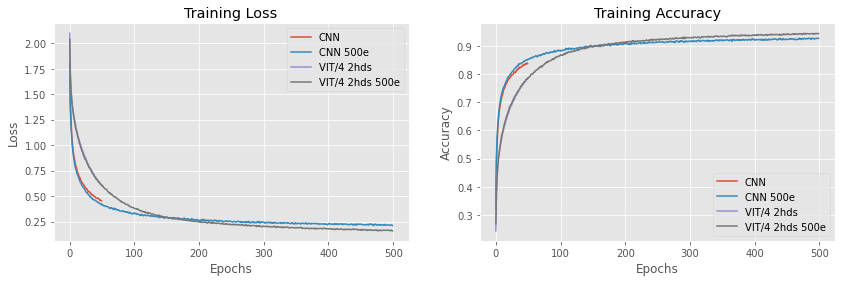

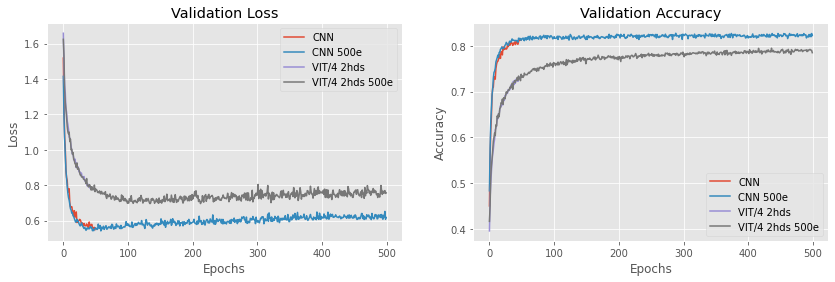

In [46]:
legends = ['CNN', 'CNN 500e', 'VIT/4 2hds', 'VIT/4 2hds 500e']
histories = [history_cnn, history_cnn_500epoch, 
             history_vit_4x4_2hd, history_vit_4x4_2hd_500epoch]

plot([i.history['loss'] for i in histories], 
     [i.history['sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Training Loss', 'Training Accuracy'])
plot([i.history['val_loss'] for i in histories], 
     [i.history['val_sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Validation Loss', 'Validation Accuracy'])

In [47]:
%%script false
# This is just for reference.

# batch_size = 256
# epochs = 1
# model = VIT(num_classes=num_classes, 
#             image_height=image_height, 
#             image_width=image_width,
#             patch_size=4, 
#             projection_dim=32,
#             num_layers=4,
#             num_heads=2,
#             mlp_dims=[64, 32],
#             classifier_mlp_dims=[512],
#             preprocess=False).model()
# train_and_eval(model, 'DUMMY_VIT')
# model.evaluate(data_generator('val', batch_size))
# model_VIT = tf.keras.models.load_model('DUMMY_VIT')
# Somehow the load model does not always load the variables.
# model_VIT.load_weights('DUMMY_VIT/variables/variables')
# model_VIT.evaluate(data_generator('val', batch_size))